In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tiffile as tiff
import glob
import re
import random
import pyminimax
from astropy.visualization import hist as histo
from scipy.spatial.distance import squareform,pdist,cdist
from scipy.stats import spearmanr, wasserstein_distance as wasserstein
from scipy.cluster import hierarchy as hc
from difflib import ndiff
from sklearn.metrics import silhouette_score, calinski_harabasz_score, pairwise_distances
from scipy.ndimage._morphology import distance_transform_cdt as dist_form
import statsmodels.formula.api as smf
from scipy.spatial import distance 
from scipy.stats import false_discovery_control
import seaborn as sns
import pandas as pd

def poly_area(x, y):
    r"""
    A function that computes the polygonal area via the shoelace formula.

    This function allows you to take the area of any polygon that is not self
    intersecting. This is also known as Gauss's area formula. See
    https://en.wikipedia.org/wiki/Shoelace_formula

    Parameters
    ----------
    x : ndarray (1-D)
        the x locations of a polygon
    y : ndarray (1-D)
        the y locations of the polygon

    Returns
    -------
    area : float
        the calculated polygonal area

    Notes
    -----
    The x and y locations need to be ordered such that the first vertex
    of the polynomial correspounds to x[0] and y[0], the second vertex
    x[1] and y[1] and so forth


    Thanks to Mahdi for this one line code
    https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
    """
    return 0.5*np.abs(np.dot(x, np.roll(y, 1))-np.dot(y, np.roll(x, 1)))

def is_simple_quad(ab, bc, cd, da):
    r"""
    Returns True if a quadrilateral is simple

    This function performs cross products at the vertices of a quadrilateral.
    It is possible to use the results to decide whether a quadrilateral is
    simple or complex. This function returns True if the quadrilateral is
    simple, and False if the quadrilateral is complex. A complex quadrilateral
    is a self-intersecting quadrilateral.

    Parameters
    ----------
    ab : array_like
        [x, y] location of the first vertex
    bc : array_like
        [x, y] location of the second vertex
    cd : array_like
        [x, y] location of the third vertex
    da : array_like
        [x, y] location of the fourth vertex

    Returns
    -------
    simple : bool
        True if quadrilateral is simple, False if complex
    """
    #   Compute all four cross products
    temp0 = np.cross(ab, bc)
    temp1 = np.cross(bc, cd)
    temp2 = np.cross(cd, da)
    temp3 = np.cross(da, ab)
    cross = np.array([temp0, temp1, temp2, temp3])
    #   See that majority of cross products is non-positive or non-negative
    #   They don't necessarily need to lie in the same 'Z' direction
    if sum(cross > 0) < sum(cross < 0):
        crossTF = cross <= 0
    else:
        crossTF = cross >= 0
    return sum(crossTF) > 2


def makeQuad(x, y):
    r"""
    Calculate the area from the x and y locations of a quadrilateral

    This function first constructs a simple quadrilateral from the x and y
    locations of the vertices of the quadrilateral. The function then
    calculates the shoelace area of the simple quadrilateral.

    Parameters
    ----------
    x : array_like
        the x locations of a quadrilateral
    y : array_like
        the y locations of a quadrilateral

    Returns
    -------
    area : float
        Area of quadrilateral via shoelace formula

    Notes
    -----
    This function rearranges the vertices of a quadrilateral until the
    quadrilateral is "Simple" (meaning non-complex). Once a simple
    quadrilateral is found, the area of the quadrilateral is calculated
    using the shoelace formula.
    """

    # check to see if the provide point order is valid
    # I need to get the values of the cross products of ABxBC, BCxCD, CDxDA,
    # DAxAB, thus I need to create the following arrays AB, BC, CD, DA

    AB = [x[1]-x[0], y[1]-y[0]]
    BC = [x[2]-x[1], y[2]-y[1]]
    CD = [x[3]-x[2], y[3]-y[2]]
    DA = [x[0]-x[3], y[0]-y[3]]

    isQuad = is_simple_quad(AB, BC, CD, DA)

    if isQuad is False:
        # attempt to rearrange the first two points
        x[1], x[0] = x[0], x[1]
        y[1], y[0] = y[0], y[1]
        AB = [x[1]-x[0], y[1]-y[0]]
        BC = [x[2]-x[1], y[2]-y[1]]
        CD = [x[3]-x[2], y[3]-y[2]]
        DA = [x[0]-x[3], y[0]-y[3]]

        isQuad = is_simple_quad(AB, BC, CD, DA)

        if isQuad is False:
            # place the second and first points back where they were, and
            # swap the second and third points
            x[2], x[0], x[1] = x[0], x[1], x[2]
            y[2], y[0], y[1] = y[0], y[1], y[2]
            AB = [x[1]-x[0], y[1]-y[0]]
            BC = [x[2]-x[1], y[2]-y[1]]
            CD = [x[3]-x[2], y[3]-y[2]]
            DA = [x[0]-x[3], y[0]-y[3]]

            isQuad = is_simple_quad(AB, BC, CD, DA)

    # calculate the area via shoelace formula
    area = poly_area(x, y)
    return area



def get_arc_length(dataset):
    r"""
    Obtain arc length distances between every point in 2-D space

    Obtains the total arc length of a curve in 2-D space (a curve of x and y)
    as well as the arc lengths between each two consecutive data points of the
    curve.

    Parameters
    ----------
    dataset : ndarray (2-D)
        The dataset of the curve in 2-D space.

    Returns
    -------
    arcLength : float
        The sum of all consecutive arc lengths
    arcLengths : array_like
        A list of the arc lengths between data points

    Notes
    -----
    Your x locations of data points should be dataset[:, 0], and the y
    locations of the data points should be dataset[:, 1]
    """
    #   split the dataset into two discrete datasets, each of length m-1
    m = len(dataset)
    a = dataset[0:m-1, :]
    b = dataset[1:m, :]
    #   use scipy.spatial to compute the euclidean distance
    dataDistance = distance.cdist(a, b, 'euclidean')
    #   this returns a matrix of the euclidean distance between all points
    #   the arc length is simply the sum of the diagonal of this matrix
    arcLengths = np.diagonal(dataDistance)
    arcLength = sum(arcLengths)
    return arcLength, arcLengths


def makeQuad(x, y):
    r"""
    Calculate the area from the x and y locations of a quadrilateral

    This function first constructs a simple quadrilateral from the x and y
    locations of the vertices of the quadrilateral. The function then
    calculates the shoelace area of the simple quadrilateral.

    Parameters
    ----------
    x : array_like
        the x locations of a quadrilateral
    y : array_like
        the y locations of a quadrilateral

    Returns
    -------
    area : float
        Area of quadrilateral via shoelace formula

    Notes
    -----
    This function rearranges the vertices of a quadrilateral until the
    quadrilateral is "Simple" (meaning non-complex). Once a simple
    quadrilateral is found, the area of the quadrilateral is calculated
    using the shoelace formula.
    """

    # check to see if the provide point order is valid
    # I need to get the values of the cross products of ABxBC, BCxCD, CDxDA,
    # DAxAB, thus I need to create the following arrays AB, BC, CD, DA

    AB = [x[1]-x[0], y[1]-y[0]]
    BC = [x[2]-x[1], y[2]-y[1]]
    CD = [x[3]-x[2], y[3]-y[2]]
    DA = [x[0]-x[3], y[0]-y[3]]

    isQuad = is_simple_quad(AB, BC, CD, DA)

    if isQuad is False:
        # attempt to rearrange the first two points
        x[1], x[0] = x[0], x[1]
        y[1], y[0] = y[0], y[1]
        AB = [x[1]-x[0], y[1]-y[0]]
        BC = [x[2]-x[1], y[2]-y[1]]
        CD = [x[3]-x[2], y[3]-y[2]]
        DA = [x[0]-x[3], y[0]-y[3]]

        isQuad = is_simple_quad(AB, BC, CD, DA)

        if isQuad is False:
            # place the second and first points back where they were, and
            # swap the second and third points
            x[2], x[0], x[1] = x[0], x[1], x[2]
            y[2], y[0], y[1] = y[0], y[1], y[2]
            AB = [x[1]-x[0], y[1]-y[0]]
            BC = [x[2]-x[1], y[2]-y[1]]
            CD = [x[3]-x[2], y[3]-y[2]]
            DA = [x[0]-x[3], y[0]-y[3]]

            isQuad = is_simple_quad(AB, BC, CD, DA)

    # calculate the area via shoelace formula
    area = poly_area(x, y)
    return area
def area_between_two_curves(exp_data, num_data):
    r"""
    Calculates the area between two curves.

    This calculates the area according to the algorithm in [1]_. Each curve is
    constructed from discretized data points in 2-D space, e.g. each curve
    consists of x and y data points.

    Parameters
    ----------
    exp_data : ndarray (2-D)
        Curve from your experimental data.
    num_data : ndarray (2-D)
        Curve from your numerical data.

    Returns
    -------
    area : float
        The area between exp_data and num_data curves.

    References
    ----------
    .. [1] Jekel, C. F., Venter, G., Venter, M. P., Stander, N., & Haftka, R.
        T. (2018). Similarity measures for identifying material parameters from
        hysteresis loops using inverse analysis. International Journal of
        Material Forming. https://doi.org/10.1007/s12289-018-1421-8

    Notes
    -----
    Your x locations of data points should be exp_data[:, 0], and the y
    locations of the data points should be exp_data[:, 1]. Same for num_data.
    """
    # Calculate the area between two curves using quadrilaterals
    # Consider the test data to be data from an experimental test as exp_data
    # Consider the computer simulation (results from numerical model) to be
    # num_data
    #
    # Example on formatting the test and history data:
    # Curve1 = [xi1, eta1]
    # Curve2 = [xi2, eta2]
    # exp_data = np.zeros([len(xi1), 2])
    # num_data = np.zeros([len(xi2), 2])
    # exp_data[:,0] = xi1
    # exp_data[:,1] = eta1
    # num_data[:, 0] = xi2
    # num_data[:, 1] = eta2
    #
    # then you can calculate the area as
    # area = area_between_two_curves(exp_data, num_data)

    n_exp = len(exp_data)
    n_num = len(num_data)

    # the length of exp_data must be larger than the length of num_data
    if n_exp < n_num:
        temp = num_data.copy()
        num_data = exp_data.copy()
        exp_data = temp.copy()
        n_exp = len(exp_data)
        n_num = len(num_data)

    # get the arc length data of the curves
    # arcexp_data, _ = get_arc_length(exp_data)
    _, arcsnum_data = get_arc_length(num_data)

    # let's find the largest gap between point the num_data, and then
    # linearally interpolate between these points such that the num_data
    # becomes the same length as the exp_data
    for i in range(0, n_exp-n_num):
        a = num_data[0:n_num-1, 0]
        b = num_data[1:n_num, 0]
        nIndex = np.argmax(arcsnum_data)
        newX = (b[nIndex] + a[nIndex])/2.0
        #   the interpolation model messes up if x2 < x1 so we do a quick check
        if a[nIndex] < b[nIndex]:
            newY = np.interp(newX, [a[nIndex], b[nIndex]],
                             [num_data[nIndex, 1], num_data[nIndex+1, 1]])
        else:
            newY = np.interp(newX, [b[nIndex], a[nIndex]],
                             [num_data[nIndex+1, 1], num_data[nIndex, 1]])
        num_data = np.insert(num_data, nIndex+1, newX, axis=0)
        num_data[nIndex+1, 1] = newY

        _, arcsnum_data = get_arc_length(num_data)
        n_num = len(num_data)

    # Calculate the quadrilateral area, by looping through all of the quads
    area = []
    for i in range(1, n_exp):
        tempX = [exp_data[i-1, 0], exp_data[i, 0], num_data[i, 0],
                 num_data[i-1, 0]]
        tempY = [exp_data[i-1, 1], exp_data[i, 1], num_data[i, 1],
                 num_data[i-1, 1]]
        area.append(makeQuad(tempX, tempY))
    return np.sum(area)

def coef_plot(model):
    lin_reg = model
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    err_series
    coef_df = pd.DataFrame({'coef': lin_reg.params.values[1:-1],
                            'err': err_series.values[1:-1],
                            'varname': err_series.index.values[1:-1]
                           })
    fig, ax = plt.subplots(figsize=(8, 5))
    coef_df.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')

def r2(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    correlation = np.corrcoef(x, y)[0,1]

     # r
    results['correlation'] = correlation
     # r-squared
    results['determination'] = correlation**2

    return results
    
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)
def entropy(binary_image):
    cancer_cells = np.sum(binary_image * 1)
    col_divided = blockshaped(binary_image,100,100)
    
    list_of_entropies = []
    
    for instance in col_divided:
        number_of_cells = np.sum(instance * 1)
        #print(number_of_cells)
        if number_of_cells != 0:
            small_n = np.sum(number_of_cells * 1)
            ent_time = small_n / cancer_cells
            frame = ent_time * np.log(ent_time)
            list_of_entropies.append(-frame)
        else:
            list_of_entropies.append(0)
    return(list_of_entropies)


def frechet_dist(exp_data, num_data, p=2):
    r"""
    Compute the discrete Frechet distance

    Compute the Discrete Frechet Distance between two N-D curves according to
    [1]_. The Frechet distance has been defined as the walking dog problem.
    From Wikipedia: "In mathematics, the Frechet distance is a measure of
    similarity between curves that takes into account the location and
    ordering of the points along the curves. It is named after Maurice Frechet.
    https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance

    Parameters
    ----------
    exp_data : array_like
        Curve from your experimental data. exp_data is of (M, N) shape, where
        M is the number of data points, and N is the number of dimmensions
    num_data : array_like
        Curve from your numerical data. num_data is of (P, N) shape, where P
        is the number of data points, and N is the number of dimmensions
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.

    Returns
    -------
    df : float
        discrete Frechet distance

    References
    ----------
    .. [1] Thomas Eiter and Heikki Mannila. Computing discrete Frechet
        distance. Technical report, 1994.
        http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.937&rep=rep1&type=pdf

    Notes
    -----
    Your x locations of data points should be exp_data[:, 0], and the y
    locations of the data points should be exp_data[:, 1]. Same for num_data.

    Thanks to Arbel Amir for the issue, and Sen ZHANG for the iterative code
    https://github.com/cjekel/similarity_measures/issues/6

    Examples
    --------
    >>> # Generate random experimental data
    >>> x = np.random.random(100)
    >>> y = np.random.random(100)
    >>> exp_data = np.zeros((100, 2))
    >>> exp_data[:, 0] = x
    >>> exp_data[:, 1] = y
    >>> # Generate random numerical data
    >>> x = np.random.random(100)
    >>> y = np.random.random(100)
    >>> num_data = np.zeros((100, 2))
    >>> num_data[:, 0] = x
    >>> num_data[:, 1] = y
    >>> df = frechet_dist(exp_data, num_data)

    """
    n = len(exp_data)
    m = len(num_data)
    c = cdist(exp_data, num_data, metric='minkowski', p=p)
    ca = np.ones((n, m))
    ca = np.multiply(ca, -1)
    ca[0, 0] = c[0, 0]
    for i in range(1, n):
        ca[i, 0] = max(ca[i-1, 0], c[i, 0])
    for j in range(1, m):
        ca[0, j] = max(ca[0, j-1], c[0, j])
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = max(min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1]),
                           c[i, j])
    return ca[n-1, m-1]

def plate_iterate(sorted_list,iterations,rows_to_keep,slant):
    diag_sorted = []
    for i in range(0,iterations * 2):
        diag_sort = sorted_list[i::22 + slant][:rows_to_keep] # diag
        diag_sorted.extend(diag_sort)
        print(diag_sort)
    diag_sorted =sorted_nicely(diag_sorted)
    return(diag_sorted)
#https://codereview.stackexchange.com/questions/217065/calculate-levenshtein-distance-between-two-strings-in-python
#
def levenshtein_distance_gen(str1, str2, ):
    counter = {"+": 0, "-": 0}
    for edit_code, *_ in ndiff(str1, str2):
        if edit_code == " ":
            yield max(counter.values())
            counter = {"+": 0, "-": 0}
        else: 
            counter[edit_code] += 1
    yield max(counter.values())



In [4]:

pixel_thresh = 3.5
lop_off_inteval = 116

entropies = []
full_frame_ent = []

times = []
et_measures = []
donors = []
total_intensity =[]


for donor_number in range(1,5):
    donor_location = "/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor{}/red/*tif".format(donor_number)
    print(donor_location)
    files = glob.glob(donor_location)
    print(len(files))
    accension_list =[]
    for file in files:
        accension_list.append(file.split("_")[-3])
    sorted_list = sorted_nicely(list(set(accension_list)))
    
    row_to_append = []

    for i in range(0,8):
        first_ind = i * 22
        second_ind = (i * 22) + 8
        print(first_ind,second_ind)
        fl_list = sorted_list[first_ind:second_ind]
        print(fl_list)
        rows_to_use = fl_list[0][0]
        extended_rows = list([rows_to_use + "14",rows_to_use +"15"])
        fl_list.extend(extended_rows)
        row_to_append.extend(fl_list)
        print(fl_list)

    diag_sort = row_to_append
    for element in diag_sort:
        print(element)
        matching = [s for s in files if (element + "_") in s]
        sorted_file_list = (sorted_nicely(matching))
        print(len(sorted_file_list))
        for file in sorted_file_list:
            imported_tiff = tiff.imread(file)
            resized_tiff = imported_tiff[lop_off_inteval:-lop_off_inteval,lop_off_inteval:-lop_off_inteval]
            binary_resized = resized_tiff > pixel_thresh
            cancer_pix = np.sum(binary_resized * 1)
            total_intensity.append(cancer_pix)
            ent = entropy(binary_resized)
            full_frame_ent.append(np.sum(ent))
            entropies.append(ent)      
            donors.append(donor_number)
            et_measures.append(element)
        to_l_r = range(1, len(sorted_file_list) + 1)
        range_list  = list(to_l_r)
        times.append(range_list)
        
time_out = []
for sublist in times:
    time_out.extend(sublist)




/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor1/red/*tif
20636
0 8
['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']
['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B14', 'B15']
22 30
['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C14', 'C15']
44 52
['D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
['D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D14', 'D15']
66 74
['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']
['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E14', 'E15']
88 96
['F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']
['F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F14', 'F15']
110 118
['G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9']
['G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G14', 'G15']
132 140
['H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9']
['H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H14', 'H15']
154 162
['I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
['I2', 'I3', 'I4', 'I5', 'I6

OSError: [Errno 6] Device not configured

In [ ]:
replacement_dict = {"B":2.8,"C":2.8,"D":2.0,"E":2.0,"F":1.4,"G":1.4,"H":1.0,"I":1.0,"J":.7,"K":.7,"L":0.5,"M":0.5,"N":0,"O":0} # replace for et_ratio
et_vals = [replacement_dict[i[:1]] for i in et_measures]
rasa_placement = {"2":1.0,"3":1.0,"4":0.5,"5":0.5,"6":0.25,"7":0.25,"8":0.12,"9":0.12,"10":0.06,"11":0.06,"12":0.03,"13":0.03,"14":0.15,"15":0.15}
rasa_vals = [rasa_placement[i[1:]] for i in et_measures]

print("ran")

In [ ]:
print(np.unique(rasa_vals),np.unique(et_vals))

In [ ]:
times,total_intensity,donors,full_frame_ent,et_measures,rasa_vals,et_vals
entropies_filled = np.vstack((total_intensity,donors,full_frame_ent,et_measures)).T

df = pd.DataFrame(entropies_filled, columns = ['mass','donors','entropy','experiments'])


In [ ]:
entropy_ar = []
growth_ar = []
retraction_ar = []
mass_ar = []
donor_ar = []
for j in np.unique(donors):
    #iterate donors
    for i in np.unique(et_measures):
        #iterate et measures
        to_select = (np.array(et_measures) == i) & (np.array(donors) == j)
        
        donorlected = np.array(donors)[to_select]
        entropy_selected = np.array(full_frame_ent)[to_select]
        diff_ar = np.array(total_intensity)[to_select]
        difs =np.diff(diff_ar)

        positive = np.copy(difs)
        negative = np.copy(difs)
        
        negative[negative > 0] = 0
        positive[positive < 0] = 0
        pup = np.cumsum(negative)
        ndn = np.cumsum(positive)
        #print(pup,ndn)

        entropy_ar.extend(entropy_selected[1:])
        growth_ar.extend(ndn/10000)
        retraction_ar.extend(pup/10000 * -1)
        mass_ar.extend(diff_ar[1:]/10000)
        donor_ar.extend(donorlected[1:])

In [11]:
print(len(entropy_ar),len(growth_ar),len(retraction_ar))
group_holder = np.zeros(len(entropy_ar))

10600 10600 10600


In [18]:
times,total_intensity,donors,full_frame_ent,et_measures
entropies_filled = np.vstack((retraction_ar,growth_ar,entropy_ar,mass_ar,group_holder,donor_ar)).T

df = pd.DataFrame(entropies_filled, columns = ['retract','grow','entropy','mass','groups','donors'])


In [ ]:
import warnings
warnings.filterwarnings('default')

from sklearn.model_selection import KFold

interact_mse = [] 
interact_r2 = []

nract_mse = []
nract_r2 = []

kf = KFold(n_splits = 4, shuffle = True)
splits = kf.split(df)
for i in range (0,4):
    result = next(splits, None)
    train = df.iloc[result[0]]
    test = df.iloc[result[1]]

    md = smf.glm("entropy ~ retract + grow + mass",
                     train,
                     groups=train["donors"],
                     )
    mdf = md.fit(reml=False)
    pred = mdf.predict(test)
    nract_mse.append(mse)
    gt = df["entropy"].iloc[result[1]].to_numpy()
    pred = pred.to_numpy()
    results = r2(gt,pred,1)
    nract_r2.append([results["determination"]])
    #print("INTERACTION mean squared err: %5.4f, R squared: %5.4f " % (mse, results["determination"]))
    print(mdf.summary(),mdf.bic,mdf.aic)
    coef_plot(mdf)
    md = smf.glm("entropy ~ retract * grow * mass",
                     train,
                     groups=train["donors"],
                     
                     )
    mdf = md.fit(reml=False)
    pred = mdf.predict(test)
    mse = (np.square(df["entropy"].iloc[result[1]].to_numpy() - pred.to_numpy())).mean(axis=0)
    interact_mse.append(mse)
    gt = df["entropy"].iloc[result[1]].to_numpy()
    pred = pred.to_numpy()
    results = r2(gt,pred,1)
    interact_r2.append([results["determination"]])
    #print("NO INTERACTION mean squared err: %5.4f, R squared: %5.4f \n" % (mse, results["determination"]))
    coef_plot(mdf)
    print(mdf.summary(),mdf.bic,mdf.aic)


In [ ]:
plt.scatter(interact_mse,interact_r2,c="r",label = "interaction")
plt.scatter(nract_mse,nract_r2,c="grey",label = "no interaction")
plt.ylabel("R squared")
plt.xlabel("MSE")
plt.legend()

ValueError: x and y must be the same size

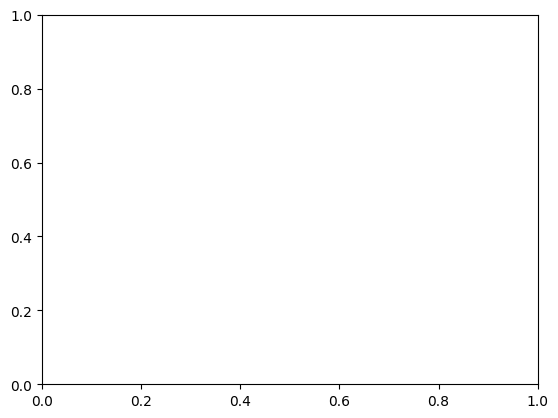

In [255]:
plt.scatter(mdf.resid,df["entropy"].iloc[result[1]].to_numpy(),c= df["mass"].iloc[result[1]].to_numpy())

In [5]:
##############################
##############################
##############################

times,total_intensity,donors,full_frame_ent,et_measures,rasa_vals,et_vals
entropies_filled = np.vstack((total_intensity,donors,full_frame_ent,rasa_vals,et_vals,time_out)).T

df = pd.DataFrame(entropies_filled, columns = ['mass','donors','entropy','rasa_perc', 'et_value', 'time'])


In [39]:
# entropies = []
# full_frame_ent = []

# times = []
# et_measures = []
# donors = []
# total_intensity =[]

# replacement_dict = {"B":2.8,"C":2.8,"D":2.0,"E":2.0} # replace for et_ratio
# et_vals = [replacement_dict[i[:1]] for i in et_measures]
# rasa_placement = {"2":100,"3":100,"4":50,"5":50,"6":25,"7":25,"8":12,"9":12,"14":15,"15":15}
# rasa_vals = [rasa_placement[i[1:]] for i in et_measures]



/Users/lepstein/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/lepstein/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/Users/lepstein/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


NO INTERACTION mean squared err: 0.0333, R squared: 0.6023 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                entropy   No. Observations:                16138
Model:                            GLM   Df Residuals:                    16134
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                        0.032732
Method:                          IRLS   Log-Likelihood:                 4694.3
Date:                Wed, 11 Dec 2024   Deviance:                       528.10
Time:                        15:57:52   Pearson chi2:                     528.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7758
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

/Users/lepstein/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/Users/lepstein/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/lepstein/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based f

                 Generalized Linear Model Regression Results                  
Dep. Variable:                entropy   No. Observations:                16138
Model:                            GLM   Df Residuals:                    16130
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                        0.027775
Method:                          IRLS   Log-Likelihood:                 6021.4
Date:                Wed, 11 Dec 2024   Deviance:                       448.01
Time:                        15:57:52   Pearson chi2:                     448.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8564
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/Users/lepstein/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


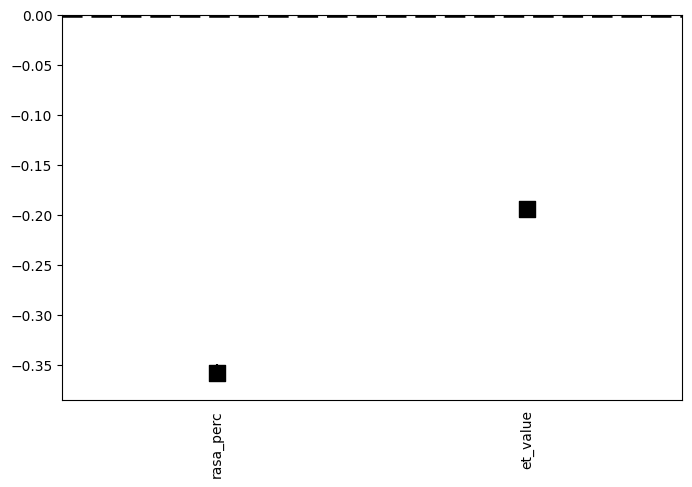

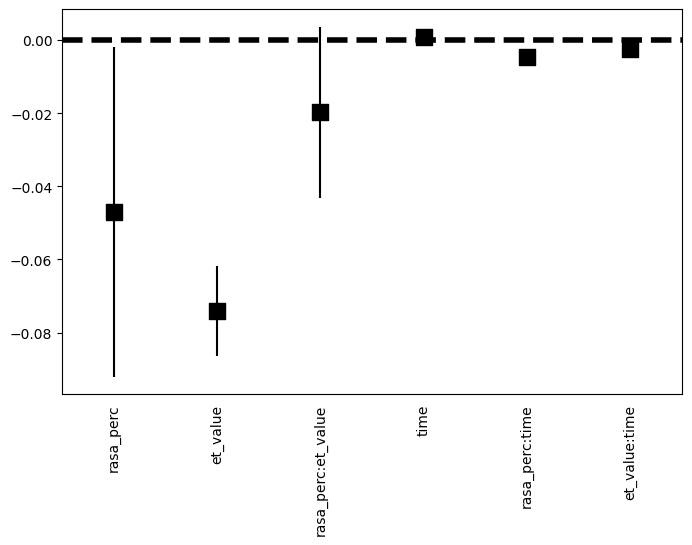

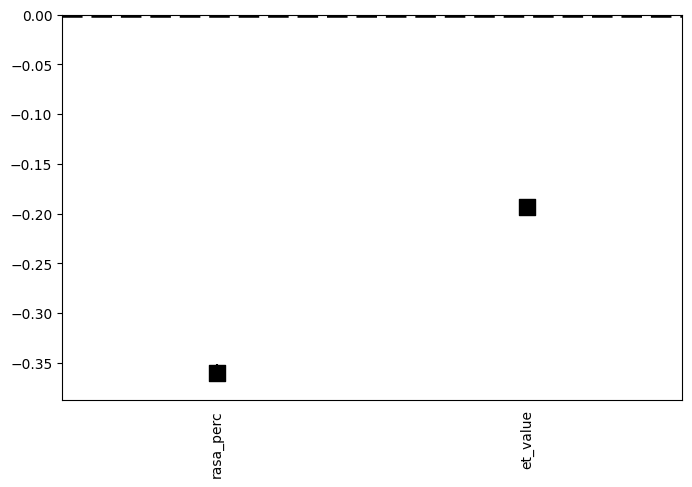

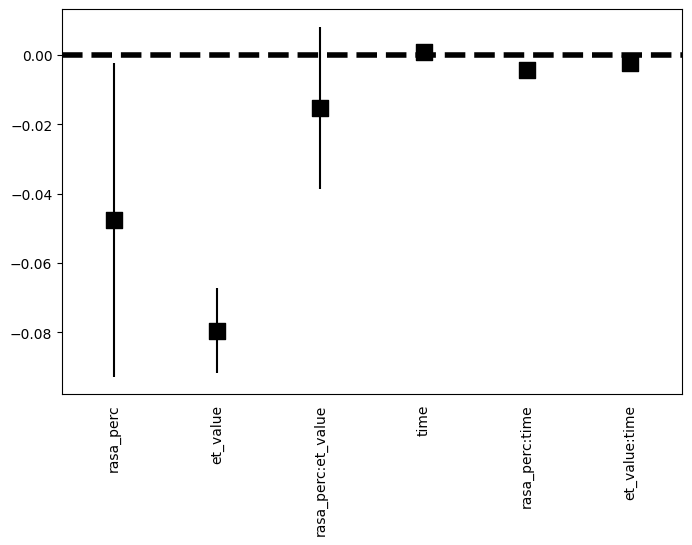

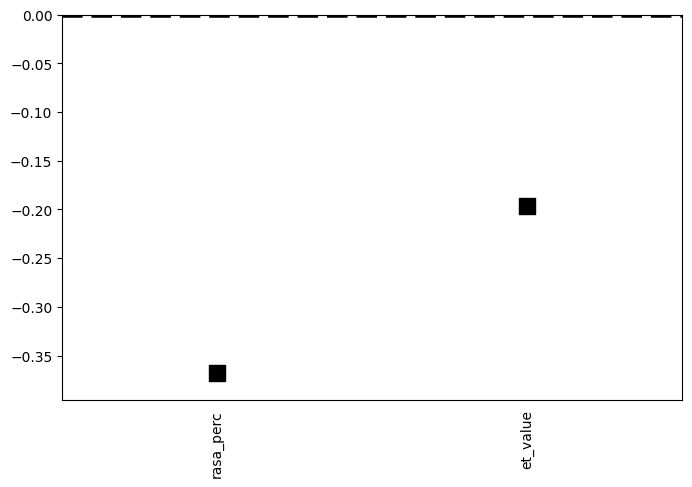

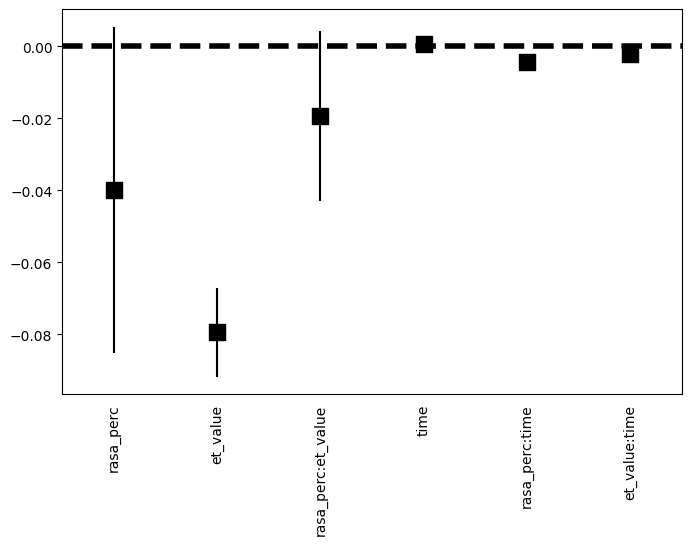

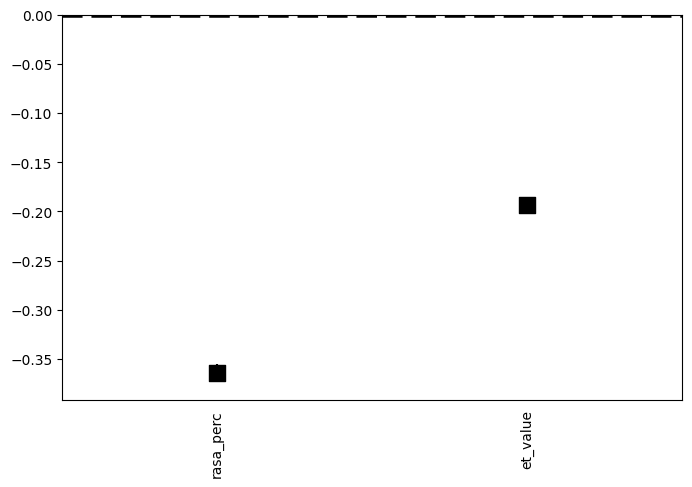

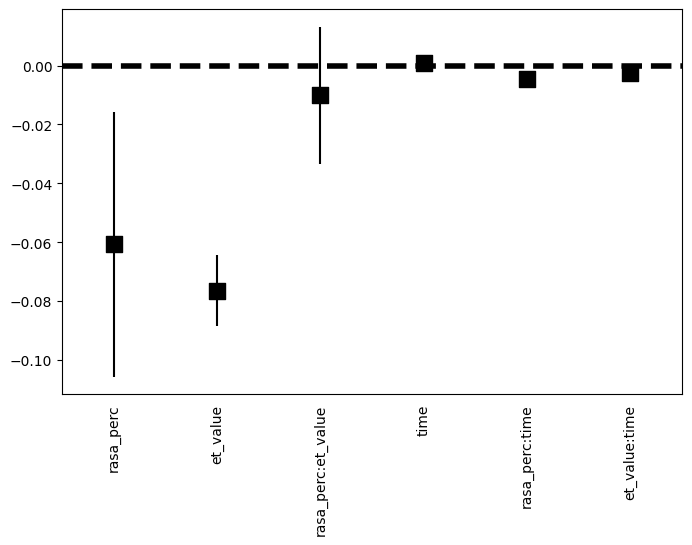

In [6]:
#BFR correect
#numerical range than rerun p vals
import warnings
warnings.filterwarnings('default')

from sklearn.model_selection import KFold

interact_mse = [] 
interact_r2 = []

nract_mse = []
nract_r2 = []

kf = KFold(n_splits = 4, shuffle = True)
splits = kf.split(df)
for i in range (0,4):
    result = next(splits, None)
    train = df.iloc[result[0]]
    test = df.iloc[result[1]]

    md = smf.mixedlm("entropy ~rasa_perc + et_value + time",
                     train,
                     groups=train["donors"],
                     )
    mdf = md.fit(reml=False)
    pred = mdf.predict(test)
    mse = (np.square(df["entropy"].iloc[result[1]].to_numpy() - pred.to_numpy())).mean(axis=0)
    nract_mse.append(mse)
    gt = df["entropy"].iloc[result[1]].to_numpy()
    pred = pred.to_numpy()
    results = r2(gt,pred,1)
    nract_r2.append([results["determination"]])
    print("NO INTERACTION mean squared err: %5.4f, R squared: %5.4f " % (mse, results["determination"]))
    print(mdf.summary(),mdf.bic,mdf.aic)
    coef_plot(mdf)
    md = smf.mixedlm("entropy ~rasa_perc * et_value * time ",
                     train,
                     groups=train["donors"],
                     )
    mdf = md.fit(reml=False)
    pred = mdf.predict(test)
    mse = (np.square(df["entropy"].iloc[result[1]].to_numpy() - pred.to_numpy())).mean(axis=0)
    interact_mse.append(mse)
    gt = df["entropy"].iloc[result[1]].to_numpy()
    pred = pred.to_numpy()
    results = r2(gt,pred,1)
    interact_r2.append([results["determination"]])
    print("INTERACTION mean squared err: %5.4f, R squared: %5.4f \n" % (mse, results["determination"]))
    coef_plot(mdf)
    print(mdf.summary(),mdf.bic,mdf.aic)


In [1]:
md = smf.mixedlm("entropy ~rasa_perc + et_value + time + mass",
                 train,
                 groups=train["donors"],
                 )
mdf = md.fit(reml=False)
pred = mdf.predict(test)
mse = (np.square(df["entropy"].iloc[result[1]].to_numpy() - pred.to_numpy())).mean(axis=0)
nract_mse.append(mse)
gt = df["entropy"].iloc[result[1]].to_numpy()
pred = pred.to_numpy()
results = r2(gt,pred,1)
nract_r2.append([results["determination"]])
print("NO INTERACTION mean squared err: %5.4f, R squared: %5.4f " % (mse, results["determination"]))
print(mdf.summary(),mdf.bic,mdf.aic)
coef_plot(mdf)

corrected_ps = false_discovery_control(mdf.pvalues)
print(np.round(corrected_ps))

NameError: name 'smf' is not defined

In [81]:
corrected_ps = false_discovery_control(mdf.pvalues)
print((corrected_ps))

[0.00000000e+00 8.45475444e-02 1.35661066e-41 4.55640116e-02
 1.06633745e-02 1.74122600e-17 2.03797138e-62 1.84690197e-13
 1.64228618e-01]


In [79]:

# interact_mse = [] 
# interact_r2 = []

# nract_mse = []
# nract_r2 = []
mdf.levels

[13792499393.015041, 14357303049.8783, 14106370367.76416, 14322216732.325636]

In [49]:
########
########entropies_filled = np.vstack((total_intensity,donors,full_frame_ent,rasa_vals,et_vals,time_out)).T
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
fig, ax = plt.subplots()
viridis = mpl.colormaps['viridis'].resampled(100)
rasa_vals
########plot out the relation between mass and sp-ent
ax.scatter(total_intensity,full_frame_ent,c = time_out,s=.6)
ax.set_ylabel("Spatial Entropy")
ax.set_xlabel("# Cancer Pixels")
#ax.set_xscale("log")
fig.colorbar(ScalarMappable(cmap=viridis, norm=plt.Normalize(0, 68)),ticks=np.arange(0,68,15), label='Frames Elapsed',ax=ax)





IndentationError: expected an indented block after 'for' statement on line 22 (3429898586.py, line 23)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

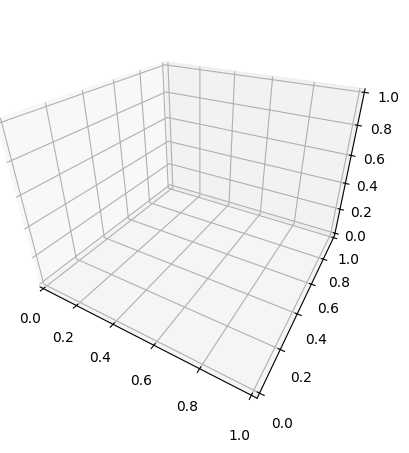

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
viridis = mpl.colormaps['magma'].resampled(100)
magma = viridis(np.linspace(0, 1, 101))
rasa_list = []
start_inds = np.where(np.array(time_out) == 1)
ax = plt.axes(projection='3d')
ax.set_proj_type('persp',.2)
for i in range(0,len(start_inds[0])-1):

    mass = np.array(total_intensity[start_inds[0][i]:start_inds[0][i + 1]])/1000
    entropys = full_frame_ent[start_inds[0][i]:start_inds[0][i + 1]]
    times = time_out[start_inds[0][i]:start_inds[0][i + 1]]
    ax.plot(entropys,mass,times, c = magma[rasa_vals[start_inds[0][i]]])
    rasa_list.append(rasa_vals[start_inds[0][i]])
ax.set_xlabel("Entropy", fontsize=10, rotation=60)
ax.set_ylabel("\n Cancer Mass \n normed", fontsize=10, rotation=85)
ax.set_zlabel("Time", fontsize=10, rotation=85)
fig.colorbar(ScalarMappable(cmap=viridis, norm=plt.Normalize(0, 100)), ticks=np.arange(100,10), label='rasa percentage',ax=ax)

Text(0.5, 0, 'Time')

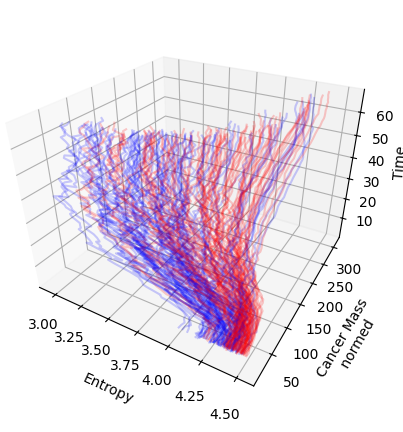

In [601]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
viridis = mpl.colormaps['magma'].resampled(100)
magma = viridis(np.linspace(0, 1, 101))
et_keeper = []
donor_keeper = []
start_inds = np.where(np.array(time_out) == 1)
ax = plt.axes(projection='3d')
ax.set_proj_type('persp',.25)
for i in range(0,len(start_inds[0])-1):
 
    mass = np.array(total_intensity[start_inds[0][i]:start_inds[0][i + 1]])/1000
    entropys = full_frame_ent[start_inds[0][i]:start_inds[0][i + 1]]
    times = time_out[start_inds[0][i]:start_inds[0][i + 1]]
    if et_vals[start_inds[0][i]]  == 2.0:
        ax.plot(entropys,mass,times, c = "red",alpha =.2)
        et_keeper.append(et_vals[start_inds[0][i]])

    else:
        et_keeper.append(et_vals[start_inds[0][i]])
        ax.plot(entropys,mass,times, c = "blue",alpha =.2)
ax.set_xlabel("Entropy", fontsize=10, rotation=60)
ax.set_ylabel("\n Cancer Mass \n normed", fontsize=10, rotation=85)
ax.set_zlabel("Time", fontsize=10, rotation=85)
#fig.colorbar(ScalarMappable(cmap=viridis, norm=plt.Normalize(0, 100)), ticks=np.arange(100,10), label='rasa percentage',ax=ax)

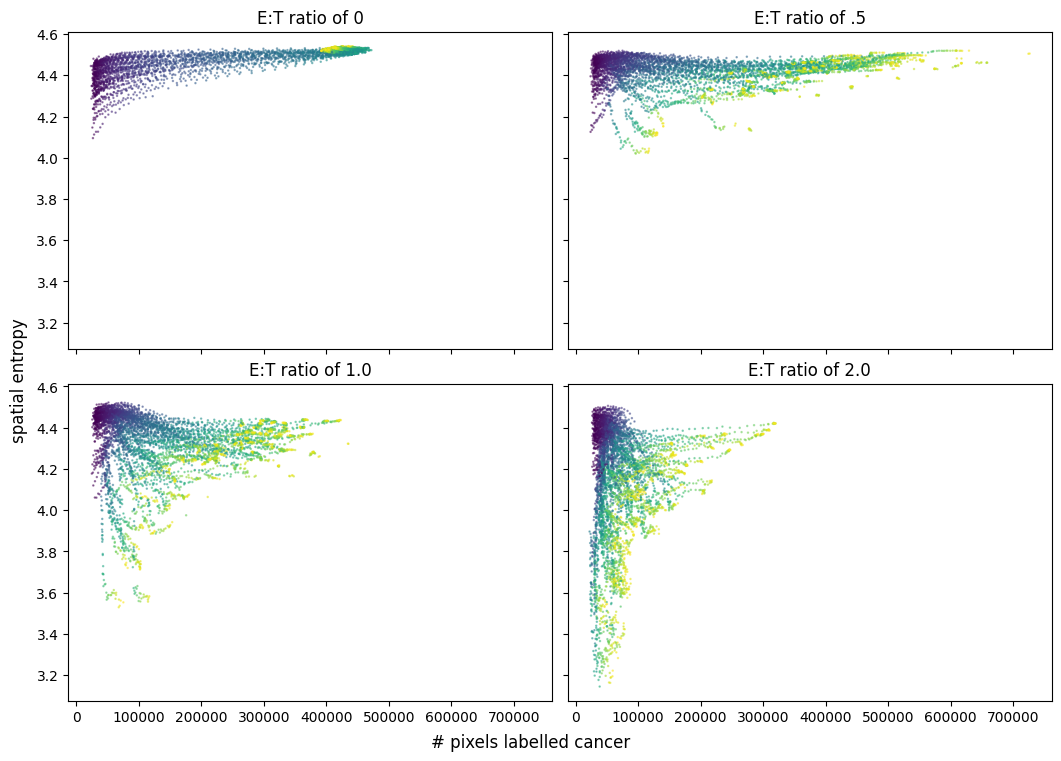

In [198]:
# replacement_dict = {"B":2.8,"C":2.8,"D":2.0,"E":2.0,"F":1.4,"G":1.4,"H":1.0,"I":1.0,"J":.7,"K":.7,"L":0.5,"M":0.5,"N":0,"O":0} # replace for et_ratio
# et_vals = [replacement_dict[i[:1]] for i in et_measures]
# rasa_placement = {"2":1.0,"3":1.0,"4":0.5,"5":0.5,"6":0.25,"7":0.25,"8":0.12,"9":0.12,"10":0.06,"11":0.06,"12":0.03,"13":0.03,"14":0.15,"15":0.15}
# rasa_vals = [rasa_placement[i[1:]] for i in et_measures]


total_intensity_ar = np.array(total_intensity)
full_frame_ent_ar = np.array(full_frame_ent)
time_out_ar = np.array(time_out)

fig, axd = plt.subplot_mosaic([['upper left','upper right'],
                               ['lower left','lower right']],
                              figsize=(10.5, 7.5), layout="constrained",sharex=True,sharey=True)

axd['upper left'].scatter(total_intensity_ar[np.array(et_vals) == 0],full_frame_ent_ar[np.array(et_vals) == 0],c = time_out_ar[np.array(et_vals) == 0],s=.6,alpha=.5)
axd['upper left'].set_title("E:T ratio of 0")

axd['upper right'].scatter(total_intensity_ar[np.array(et_vals) == 0.5],full_frame_ent_ar[np.array(et_vals) == 0.5],c = time_out_ar[np.array(et_vals) == .5],s=.6,alpha=.5)
axd['upper right'].set_title("E:T ratio of .5")

axd['lower left'].scatter(total_intensity_ar[np.array(et_vals) == 1.0],full_frame_ent_ar[np.array(et_vals) == 1.0],c = time_out_ar[np.array(et_vals) == 1.0],s=.6,alpha=.5)
axd['lower left'].set_title("E:T ratio of 1.0")

axd['lower right'].scatter(total_intensity_ar[np.array(et_vals) == 2.0],full_frame_ent_ar[np.array(et_vals) == 2.0],c = time_out_ar[np.array(et_vals) == 2.0],s=.6,alpha=.5)
axd['lower right'].set_title("E:T ratio of 2.0")

#fig.colorbar(ScalarMappable(cmap=viridis, norm=plt.Normalize(0, 68)),ticks=np.arange(0,68,15), label='Frames Elapsed',ax=axd['upper right', 'lower right'])
fig.supxlabel("# pixels labelled cancer")
fig.supylabel('spatial entropy')
plt.savefig("/Users/lepstein/Desktop/entropy_mass.png")


#### np.sum((np.array(rasa_vals) == 12) * 1)

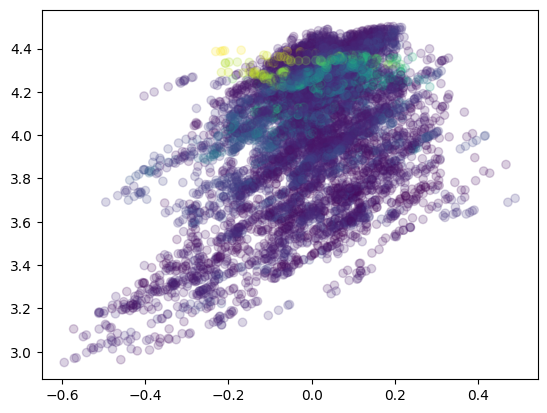

In [306]:
plt.scatter(mdf.resid,df["entropy"].iloc[result[0]].to_numpy(),c=df["mass"].iloc[result[0]].to_numpy(),alpha = .2)

In [40]:
np.unique(time_out)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68])

In [480]:
for i in range(1,7):
    print(i * 11)

11
22
33
44
55
66


In [ ]:
from scipy.spatial.distance import squareform



In [614]:
frek_dist = []
for i in range(0,len(start_inds[0])-1):

    mass = np.array(total_intensity[start_inds[0][i]:start_inds[0][i + 1]])/1000
    entropys = full_frame_ent[start_inds[0][i]:start_inds[0][i + 1]]
    mass_ent = np.array([mass,entropys])

    frek_dist.append(mass_ent)
    
master_arf = []
smoothed = []
for i in frek_dist:
    smooth_time = i[:,:66]
    dist_arr = []
    for j in frek_dist:
        dist= area_between_two_curves(i[:,:66],j[:,:66])
        dist_arr.append(dist)
    master_arf.append(dist_arr)
    smoothed.append(smooth_time)
smar = np.asarray(smoothed)
dsim = np.triu(master_arf)
condensed_dist_matrix = squareform(master_arf)
blinkage = hc.linkage(condensed_dist_matrix, method="average")


In [616]:
time_resize = np.empty((0,2,11))


for i in range(1,4):
    print(i * 11)
    bind = i - 1 
    eind = i
    tha_ar = smar[:,:, bind * 11:eind * 11]
    print(tha_ar.shape)
    time_resize = np.vstack([time_resize,tha_ar])
    
frek_dist = []

master_arf = []
smoothed = []
for i in time_resize:
    smooth_time = i[:,:66]
    dist_arr = []
    for j in time_resize:
        dist= area_between_two_curves(i[:,:66],j[:,:66])
        dist_arr.append(dist)
    master_arf.append(dist_arr)
    smoothed.append(smooth_time)
smar = np.asarray(smoothed)
dsim = np.triu(master_arf)
condensed_dist_matrix = squareform(master_arf)
blinkage = hc.linkage(condensed_dist_matrix, method="average")


11
(477, 2, 11)
22
(477, 2, 0)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 11 and the array at index 1 has size 0

In [16]:


for donor in np.unique(donors):
    spearman_1 = []
    spearman_2 = []
    spearman_3 = []
    rasa_condition = []

    donar_ind = np.array(donors) == donor
    
    for etrat in np.unique(rasa_vals):
        print(etrat)
        to_select = np.array(rasa_vals)[donar_ind] == etrat

        entropies_lected= np.array(entropies_filled)[donar_ind][to_select][:,0]        
        time_lected = np.array(time_out)[donar_ind][to_select]
        
        et_val = np.array(et_vals)[donar_ind][to_select][0]
        rasa_val = np.array(rasa_vals)[donar_ind][to_select][0]

        first = spearmanr(time_lected[:22],entropies_lected[:22])[0]        
        second = spearmanr(time_lected[22:44],entropies_lected[22:44])[0]       
        third = spearmanr(time_lected[44:],entropies_lected[44:])[0]        

        spearman_1.append(first)
        spearman_2.append(second)
        spearman_3.append(third)

        rasa_condition.append(rasa_val)
    df = np.array([rasa_condition,spearman_1])
    df = np.swapaxes(df,1,0)
    df = pd.DataFrame(df,columns=["spearman cors","rasa2 ko population percentage"])
    
    df1 = np.array([rasa_condition,spearman_2])
    df1 = np.swapaxes(df1,1,0)
    df1 = pd.DataFrame(df1,columns=["spearman cors","rasa2 ko population percentage"])
    
    df2 = np.array([rasa_condition,spearman_3])
    df2 = np.swapaxes(df2,1,0)
    df2 = pd.DataFrame(df2,columns=["spearman cors","rasa2 ko population percentage"])
    

    too_df = pd.concat({'first third': df,'second third': df1, 'last third': df2} ,names=['time_portion', 'old_index'])
    too_df = too_df.reset_index(level=0).reset_index(drop=True)
    sns.boxplot(data=too_df, y='rasa2 ko population percentage', x='spearman cors', hue='time_portion', palette='turbo')
    plt.savefig("/Users/lepstein/Downloads/{}_donor_blipo.png".format(donor))
    plt.title("Donor number:{}".format(donor))
    plt.close()
print("end")

0.12
0.15
0.25
0.5
1.0
0.12
0.15
0.25
0.5
1.0
0.12
0.15
0.25
0.5
1.0
0.12
0.15
0.25
0.5
1.0
end


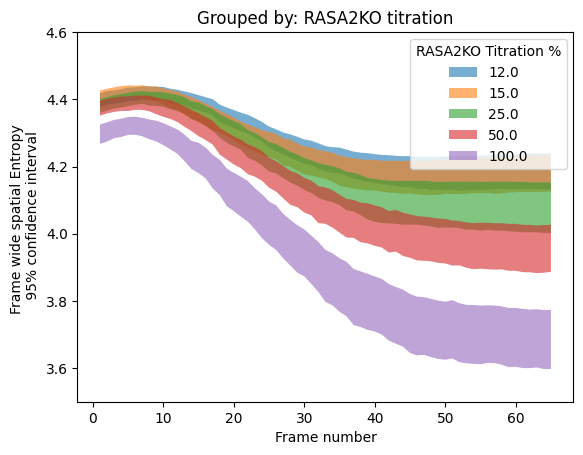

In [78]:
eles = np.arange(0,5)
import scipy
    
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))
    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


for rasa_titration in np.unique(rasa_vals):
                interval_holder0 = []
                
                rasa_to_sel = np.array(rasa_vals)
                
                first_inds = np.where((rasa_to_sel == rasa_titration))
        
                entropies_lected= np.array(entropies_filled)[first_inds][:,2].astype("float")        
                time_lected = np.array(time_out)[first_inds]
                
                for i in range(1,66):
                    tinds = time_lected == i
                            
                    mean0, blb0, bub0 = mean_confidence_interval(np.array(entropies_lected)[tinds], confidence=0.95)
                    interval0 = [mean0, blb0, bub0]
                    interval_holder0.append(interval0)
        
                interval_holder0 = np.array(interval_holder0)

                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],alpha = .6,label = rasa_titration * 100)# 100

plt.title("Grouped by: RASA2KO titration")
plt.ylabel("Frame wide spatial Entropy \n 95% confidence interval")
plt.xlabel("Frame number")
plt.ylim(3.5,4.6)
put_title= plt.legend()
put_title.set_title("RASA2KO Titration %")
plt.savefig("/Users/lepstein/Desktop/mistake/intervals_groupedby_titration.png")

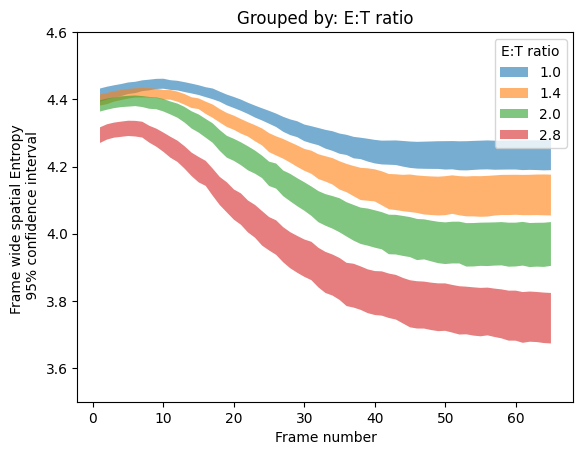

In [77]:
eles = np.arange(0,5)
import scipy
    
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))
    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


for rasa_titration in np.unique(et_vals):
                interval_holder0 = []
                
                rasa_to_sel = np.array(et_vals)
                
                first_inds = np.where((rasa_to_sel == rasa_titration))
        
                entropies_lected= np.array(entropies_filled)[first_inds][:,2].astype("float")        
                time_lected = np.array(time_out)[first_inds]
                
                for i in range(1,66):
                    tinds = time_lected == i
                            
                    mean0, blb0, bub0 = mean_confidence_interval(np.array(entropies_lected)[tinds], confidence=0.95)
                    interval0 = [mean0, blb0, bub0]
                    interval_holder0.append(interval0)
        
                interval_holder0 = np.array(interval_holder0)

                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],alpha = .6,label = rasa_titration)# 100

plt.title("Grouped by: E:T ratio")
plt.ylabel("Frame wide spatial Entropy \n 95% confidence interval")
plt.xlabel("Frame number")
plt.ylim(3.5,4.6)
put_title= plt.legend()
put_title.set_title("E:T ratio")
plt.savefig("/Users/lepstein/Desktop/mistake/intervals_groupedby_et_ratio.png")

In [26]:
eles = np.arange(0,5)
import scipy
    
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))
    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


for rasa_titration in np.unique(rasa_vals):
                interval_holder0 = []
                
                rasa_to_sel = np.array(rasa_vals)
                
                first_inds = np.where((rasa_to_sel == rasa_titration))
        
                entropies_lected= np.array(entropies_filled)[first_inds][:,2].astype("float")        
                time_lected = np.array(time_out)[first_inds]
                
                for i in range(1,66):
                    tinds = time_lected == i
                            
                    mean0, blb0, bub0 = mean_confidence_interval(np.array(entropies_lected)[tinds], confidence=0.95)
                    interval0 = [mean0, blb0, bub0]
                    interval_holder0.append(interval0)
        
                interval_holder0 = np.array(interval_holder0)

                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],alpha = .6,label = rasa_titration)# 100

plt.title("RASA2KO titration")
plt.ylabel("Frame wide spatial Entropy")
plt.xlabel("Frame number")
put_title= plt.legend()
put_title.set_title("RASA2KO Titration")

array([['26997', '1', '4.0156575693872165', 'B2'],
       ['29336', '1', '4.026309026031466', 'B2'],
       ['32169', '1', '4.064911109330392', 'B2'],
       ...,
       ['250940', '4', '4.362327230387257', 'E15'],
       ['251538', '4', '4.3644204577114145', 'E15'],
       ['252169', '4', '4.361043051615196', 'E15']], dtype='<U32')

In [ ]:
for donor in np.unique(donors):
    spearman_1 = []
    spearman_2 = []
    spearman_3 = []
    rasa_condition = []

    donar_ind = np.array(donors) == donor
    
    for etrat in np.unique(rasa_vals):
        print(etrat)
        to_select = np.array(rasa_vals)[donar_ind] == etrat

        entropies_lected= np.array(entropies_filled)[donar_ind][to_select][:,0]        
        time_lected = np.array(time_out)[donar_ind][to_select]
        
        et_val = np.array(et_vals)[donar_ind][to_select][0]
        rasa_val = np.array(rasa_vals)[donar_ind][to_select][0]

        first = spearmanr(time_lected[:22],entropies_lected[:22])[0]        
        second = spearmanr(time_lected[22:44],entropies_lected[22:44])[0]       
        third = spearmanr(time_lected[44:],entropies_lected[44:])[0]        


477 477


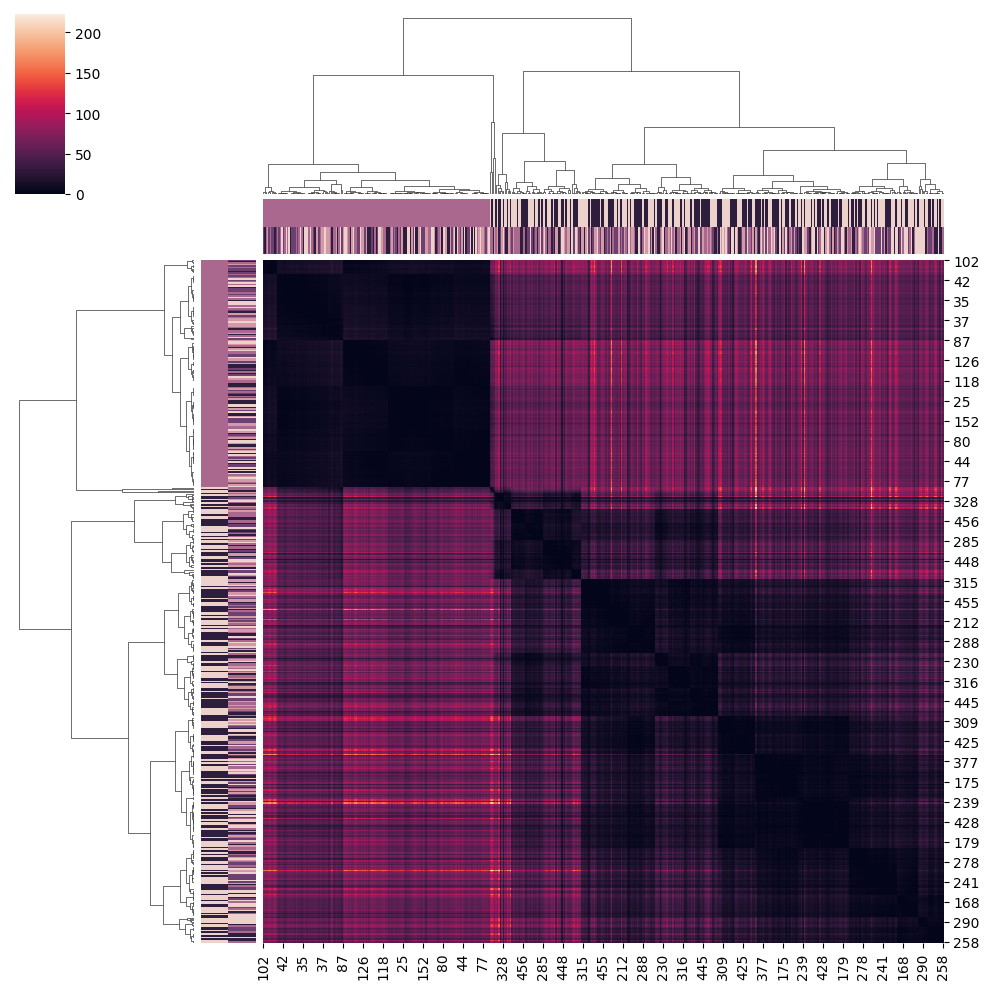

In [620]:
rep = 160/3 
list_to_rep = []

for i in range(0,4):
    donor_list= [i] * int(rep)
    list_to_rep = list_to_rep + donor_list

donors = list_to_rep[:-1] * 3
how_much = int(159)

time_portion = np.array(how_much * [100] + how_much * [200] + how_much * [300])
#et_keeper,rasa_list
e_expand = et_keeper * 3
e_expand = np.array(e_expand)
#e_expand = np.expand_dims(e_expand,1)

r_expand = rasa_list * 3
r_expand = np.array(r_expand)
#r_expand = np.expand_dims(r_expand,1)
print(len(r_expand),len(time_portion))
label_ar = np.stack([time_portion,r_expand])
# labels = pd.DataFrame(label_ar.T,columns=["time","rasa_perc","et_rat"])
labels = pd.DataFrame(label_ar.T,columns=["time","rasa"])


#labels = pd.DataFrame(np.array([time_portion,e_expand]),columns=["time","et"])
lut3 = dict(zip(set(labels["time"]), sns.cubehelix_palette(len(set(labels["time"])))))
row_colors3 = labels["time"].map(lut3)

lut2 = dict(zip(set(labels["rasa"]), sns.cubehelix_palette(len(set(labels["rasa"])))))
row_colors2 = labels["rasa"].map(lut2)

sns.clustermap(master_arf,row_linkage=blinkage,col_linkage=blinkage,row_colors=[row_colors3,row_colors2],col_colors=[row_colors3,row_colors2])


In [605]:
#looking at these clusters I think an interesting question that could be asked would be which groups have the most diversiffication
from sklearn.metrics.cluster import normalized_mutual_info_score as nims


s_score_list = []

cut_list =np.arange(2,40)
for i in range(2,40):
        print(i)
        cluster_membership = fcluster(blinkage,i,"maxclust")
        #s_score = silhouette_score(master_arf,cluster_membership,metric="precomputed")
        r_score = nims(r_expand,cluster_membership)
        t_score = nims(time_portion,cluster_membership)
        e_score = nims(e_expand,cluster_membership)

        print(r_score,t_score,e_score)




2
0.010701010266907124 0.01618716503830132 4.510866196489128e-07
3
0.03985261846923122 0.15327467379843857 0.04809892771464765
4
0.04371569645563864 0.1590054414923667 0.04902022577658474
5
0.044712492678683456 0.1624690468481027 0.04797880744719263
6
0.06220824495371044 0.18816763215083362 0.07174762809294971
7
0.06125443913831863 0.1796447587074876 0.06763938759736347
8
0.061633358201244375 0.17930412553551806 0.06922466799344797
9
0.06399632067703775 0.18199068124366483 0.06682974614196516
10
0.05933997380107632 0.3913566415768297 0.05792633806618271
11
0.060805637509726056 0.38932925351786046 0.05929282071480981
12
0.06371456750754947 0.3879966555114526 0.06140979927172395
13
0.06427774852553277 0.38746688749017705 0.06218087356131423
14
0.0685640002155651 0.36437196633726243 0.0651426255021285
15
0.06815688497928062 0.35020790236892685 0.06245159819767362
16
0.07163378066663806 0.34368530628188915 0.061687960123438364
17
0.07344262756539746 0.3440228490125171 0.06296464814556912
1

/Users/lepstein/miniconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/lepstein/miniconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/lepstein/miniconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/lepstein/miniconda3/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass 

In [414]:
s_score = silhouette_score(r_expand,cluster_membership,metric="precomputed")


ValueError: The precomputed distance matrix contains non-zero elements on the diagonal. Use np.fill_diagonal(X, 0).

In [568]:
len(et_vals)

10760

In [462]:
r_expand = rasa_list * 3
r_expand = np.array(r_expand)
r_expand = np.expand_dims(r_expand,1)

e_expand = et_keeper * 3
e_expand = np.array(e_expand)
e_expand = np.expand_dims(e_expand,1)

In [562]:
len(start_inds[0])-1

159

In [94]:
diag_sort

['B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6',
 'G7',
 'G8',
 'G9',
 'G10',
 'G11',
 'H2',
 'H3',
 'H4',
 'H5',
 'H6',
 'H7',
 'H8',
 'H9',
 'H10',
 'H11',
 'I2',
 'I3',
 'I4',
 'I5',
 'I6',
 'I7',
 'I8',
 'I9',
 'I10',
 'I11',
 'J2',
 'J3',
 'J4',
 'J5',
 'J6',
 'J7',
 'J8',
 'J9',
 'J10',
 'J11',
 'K2',
 'K3',
 'K4',
 'K5',
 'K6',
 'K7',
 'K8',
 'K9',
 'K10',
 'K11',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'L10',
 'L11',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'M10',
 'M11']

['/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d00h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d02h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d04h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d06h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d08h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d10h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d12h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d14h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncuc

['/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d00h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d02h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d04h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d06h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d08h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d10h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d12h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_00d14h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncuc

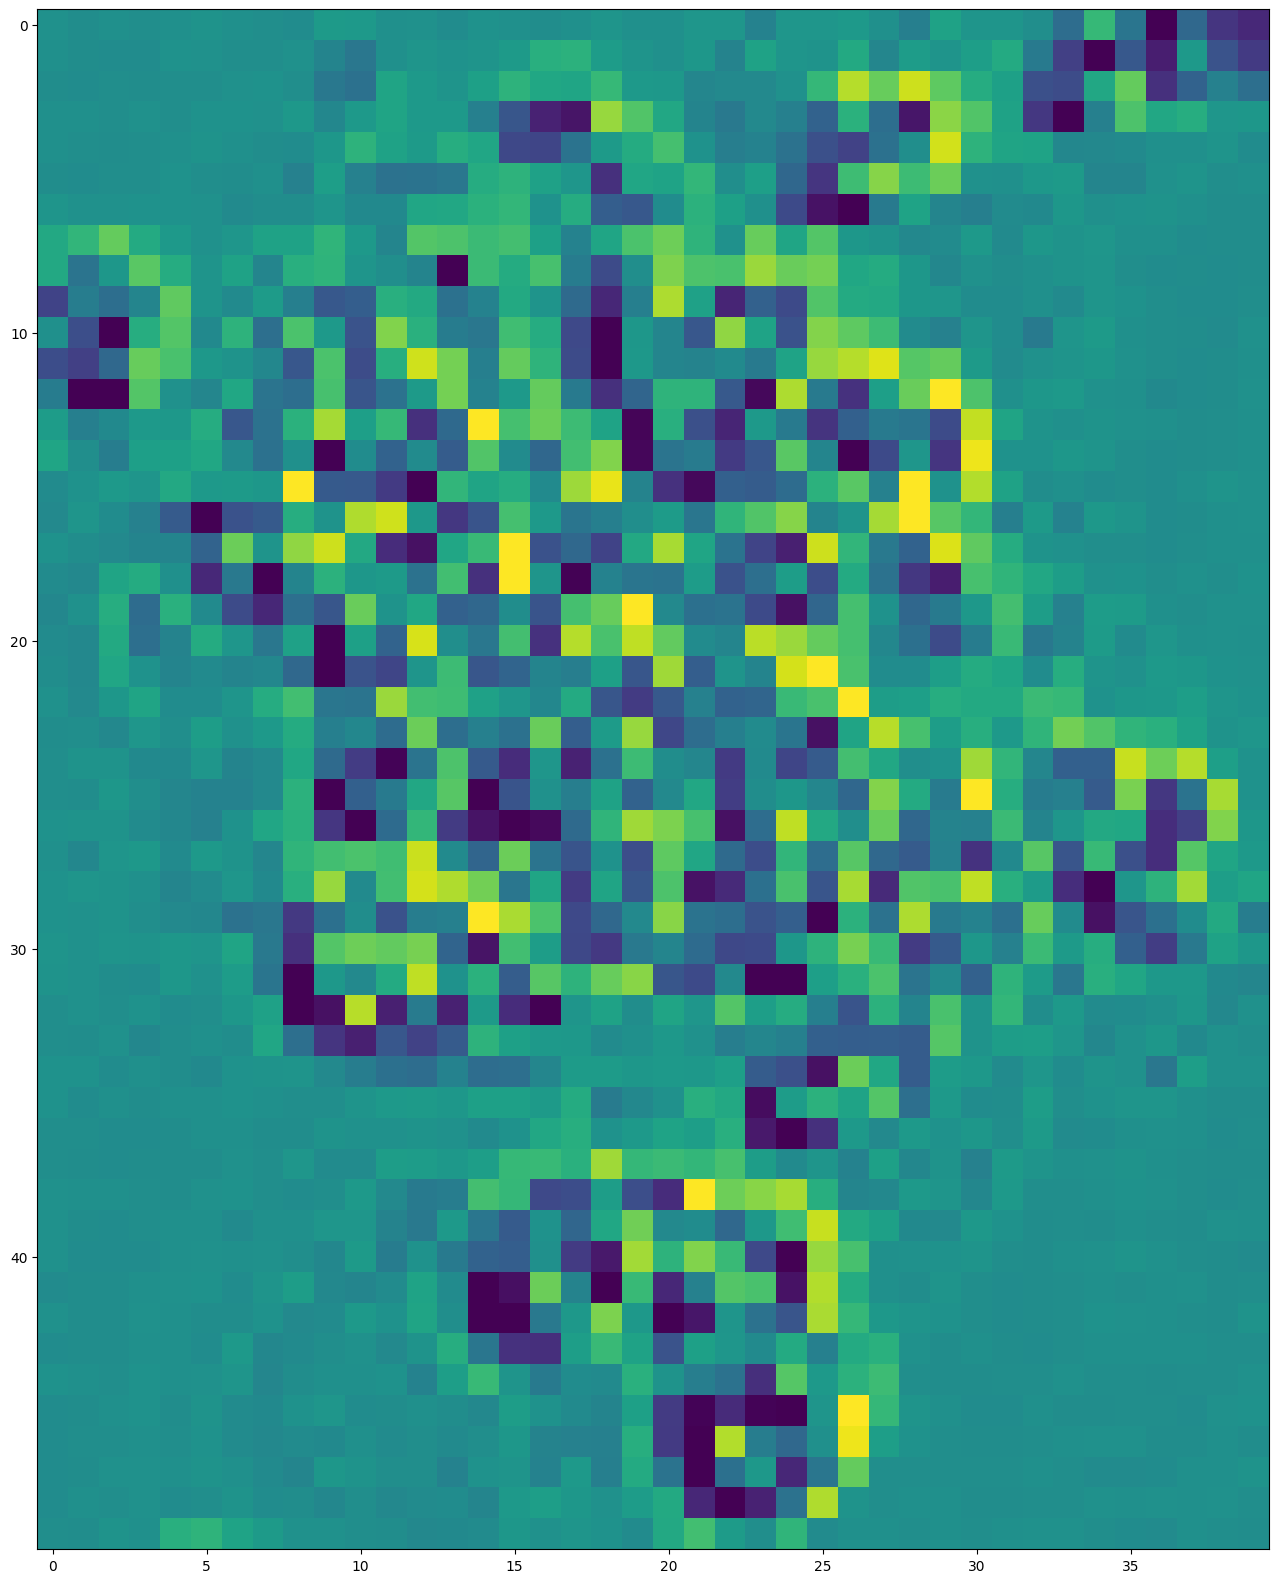

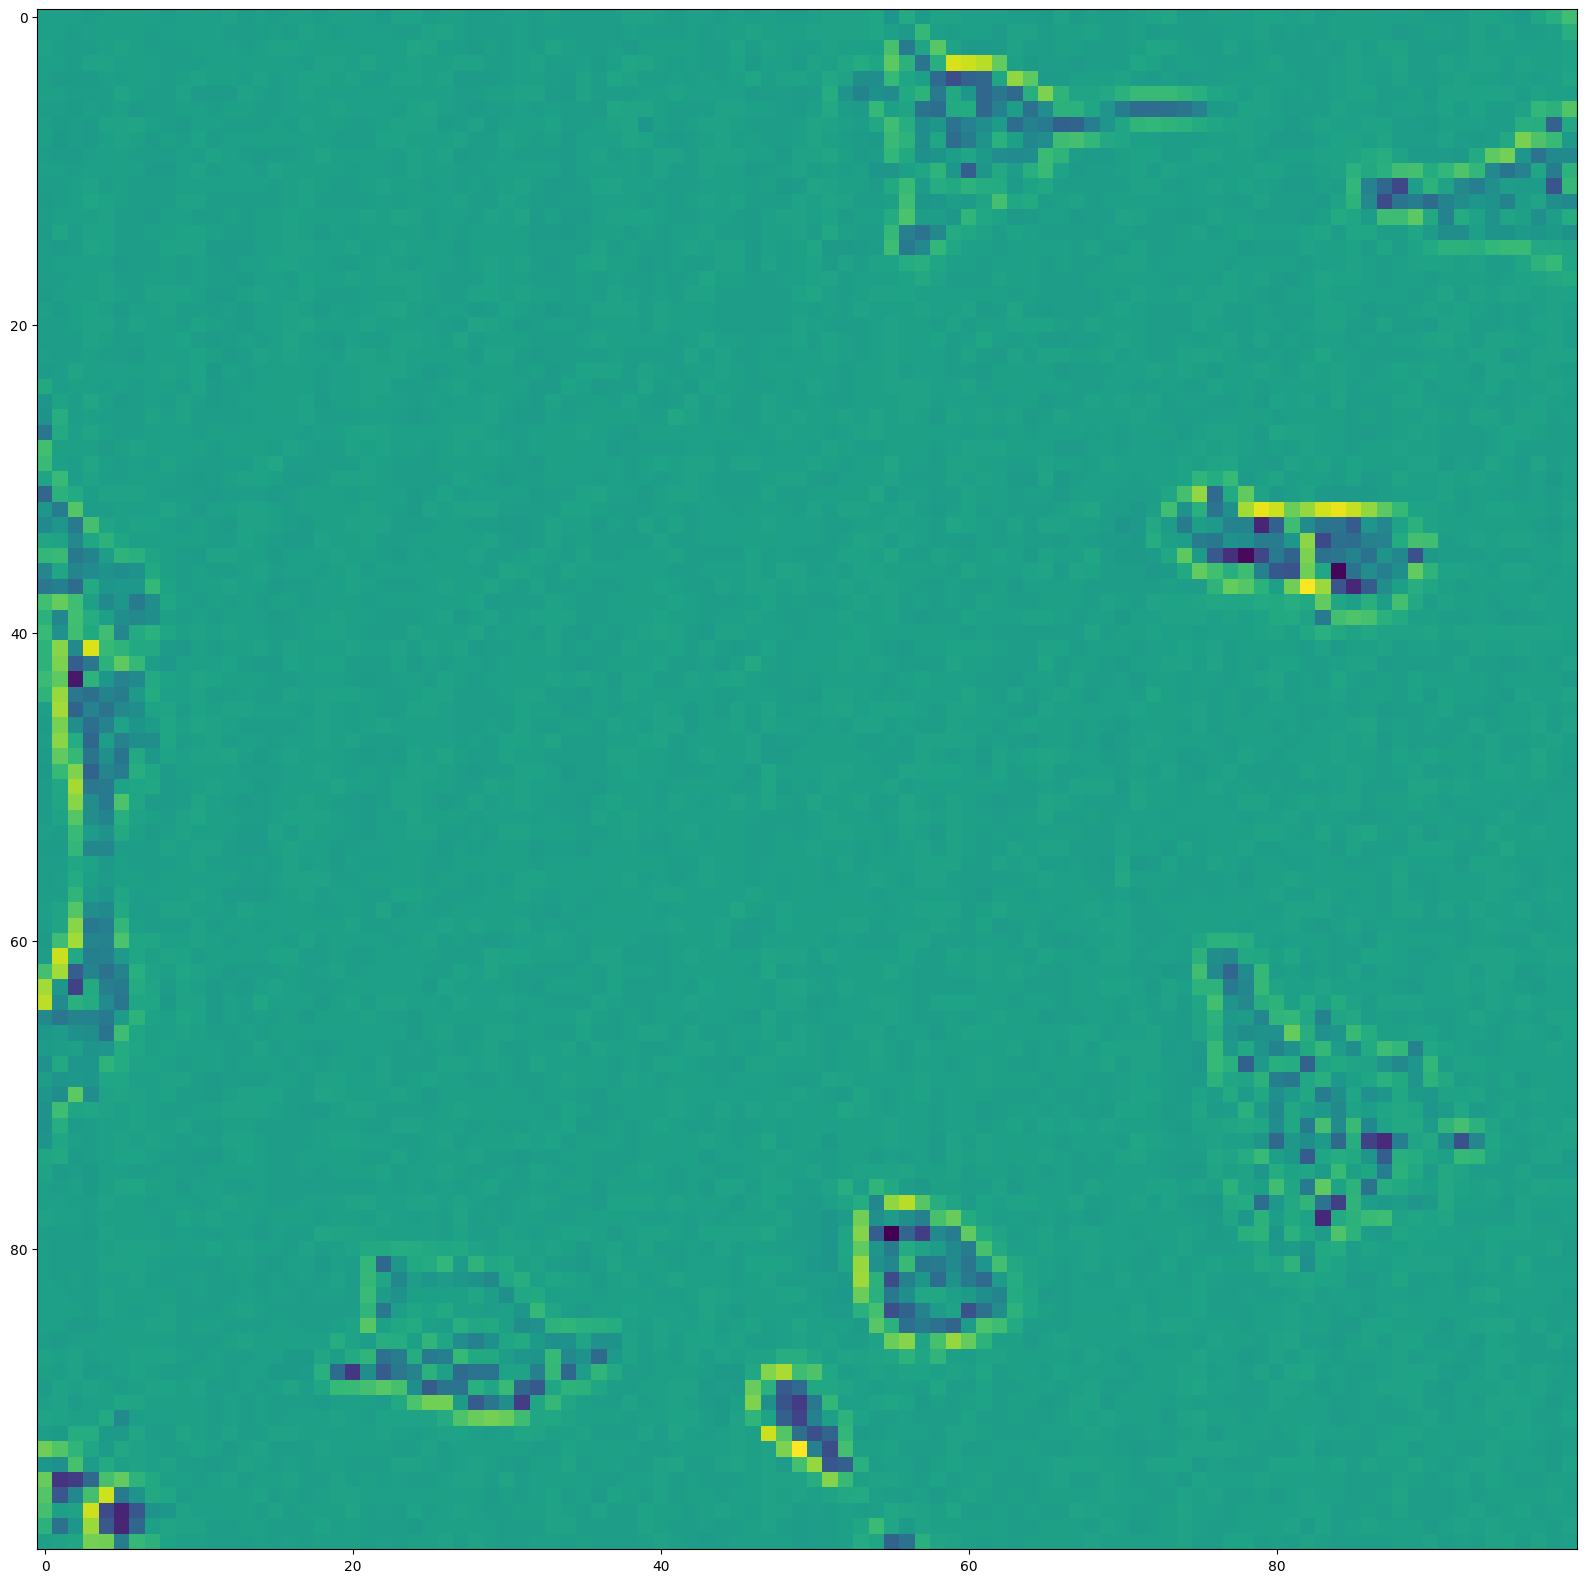

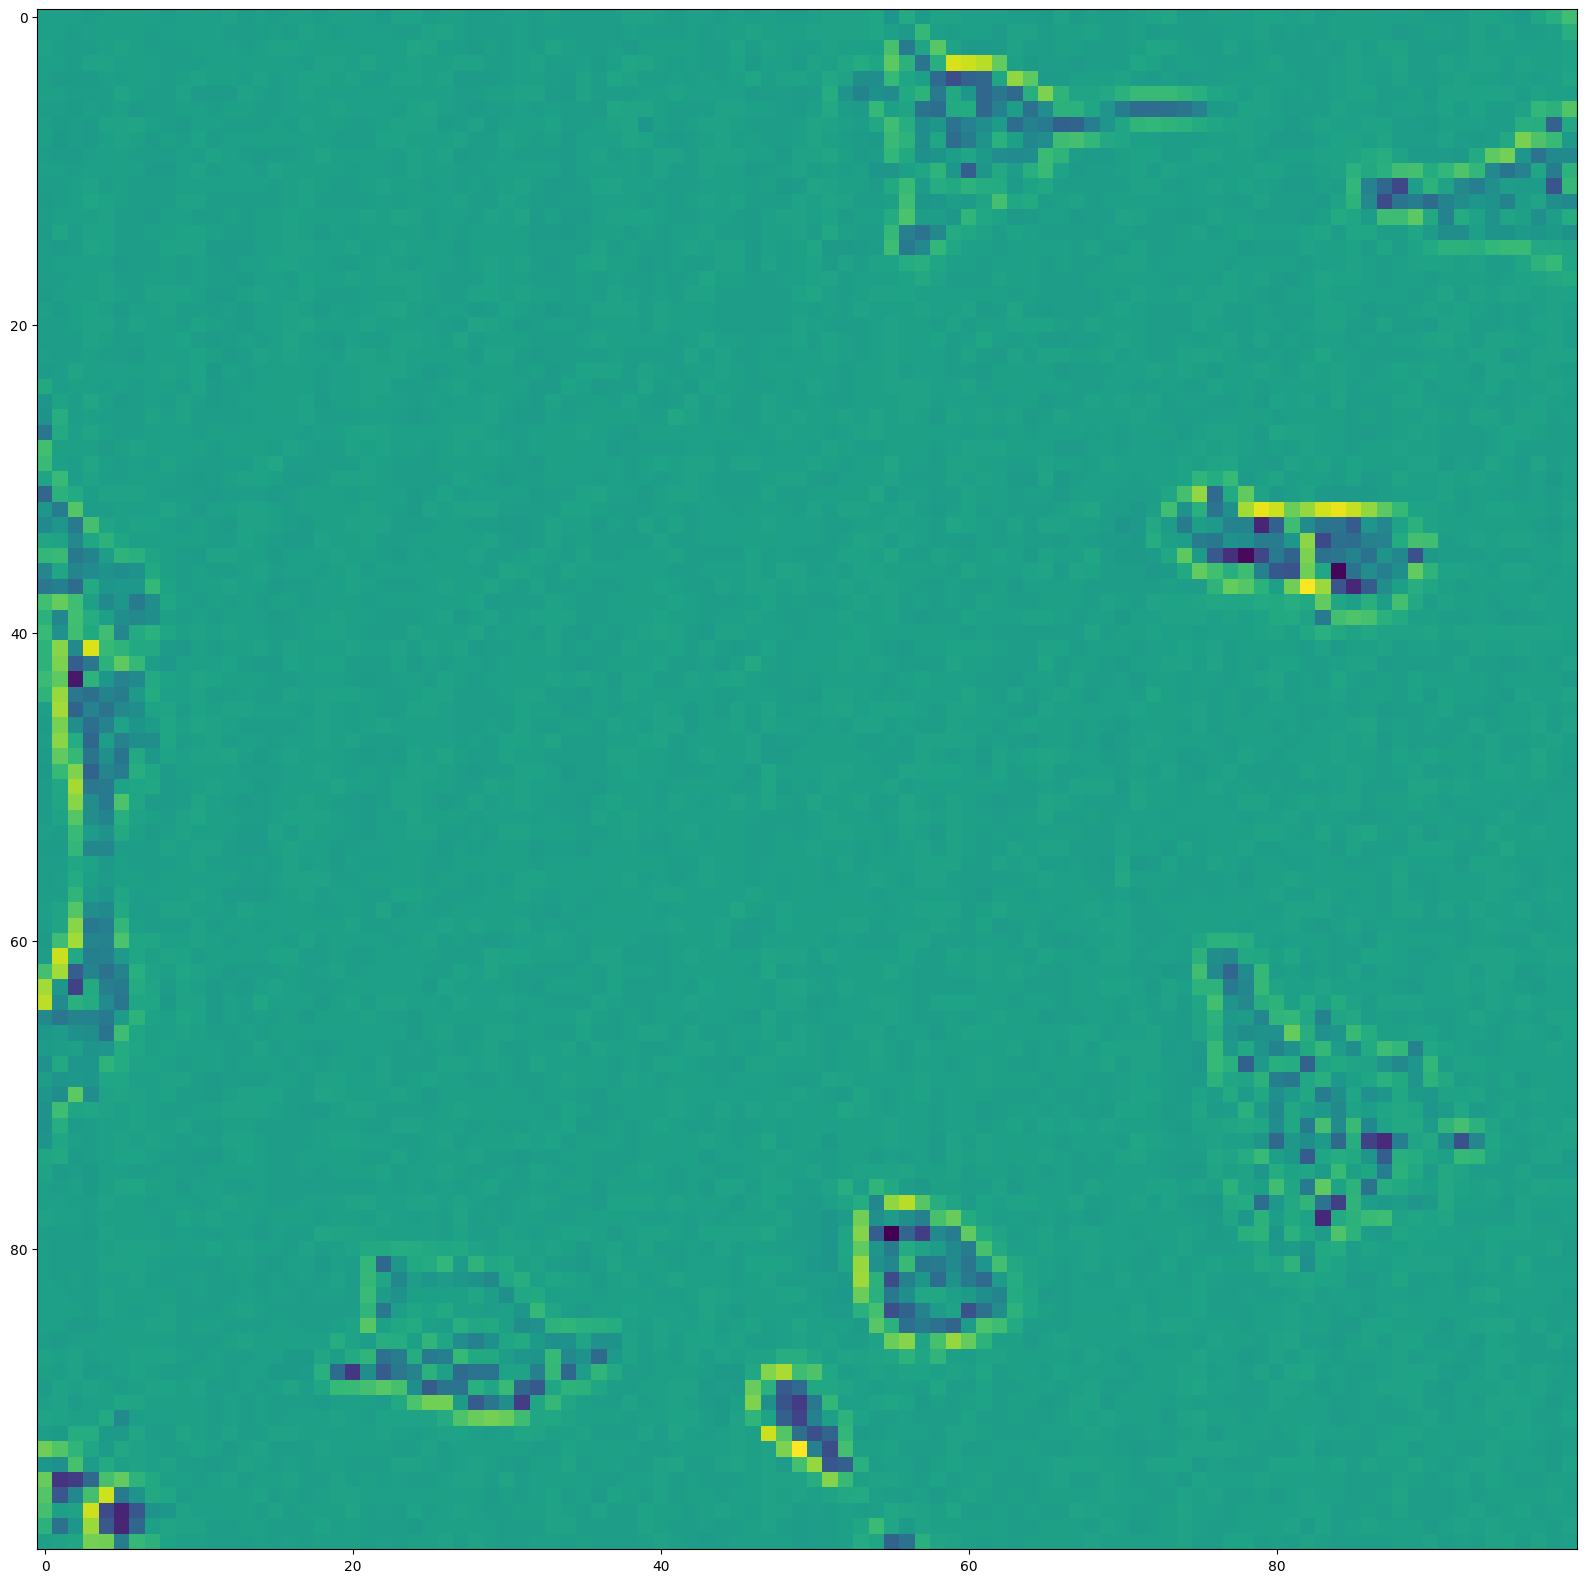

['/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d00h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d02h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d04h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d06h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d08h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d10h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d12h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_00d14h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncuc

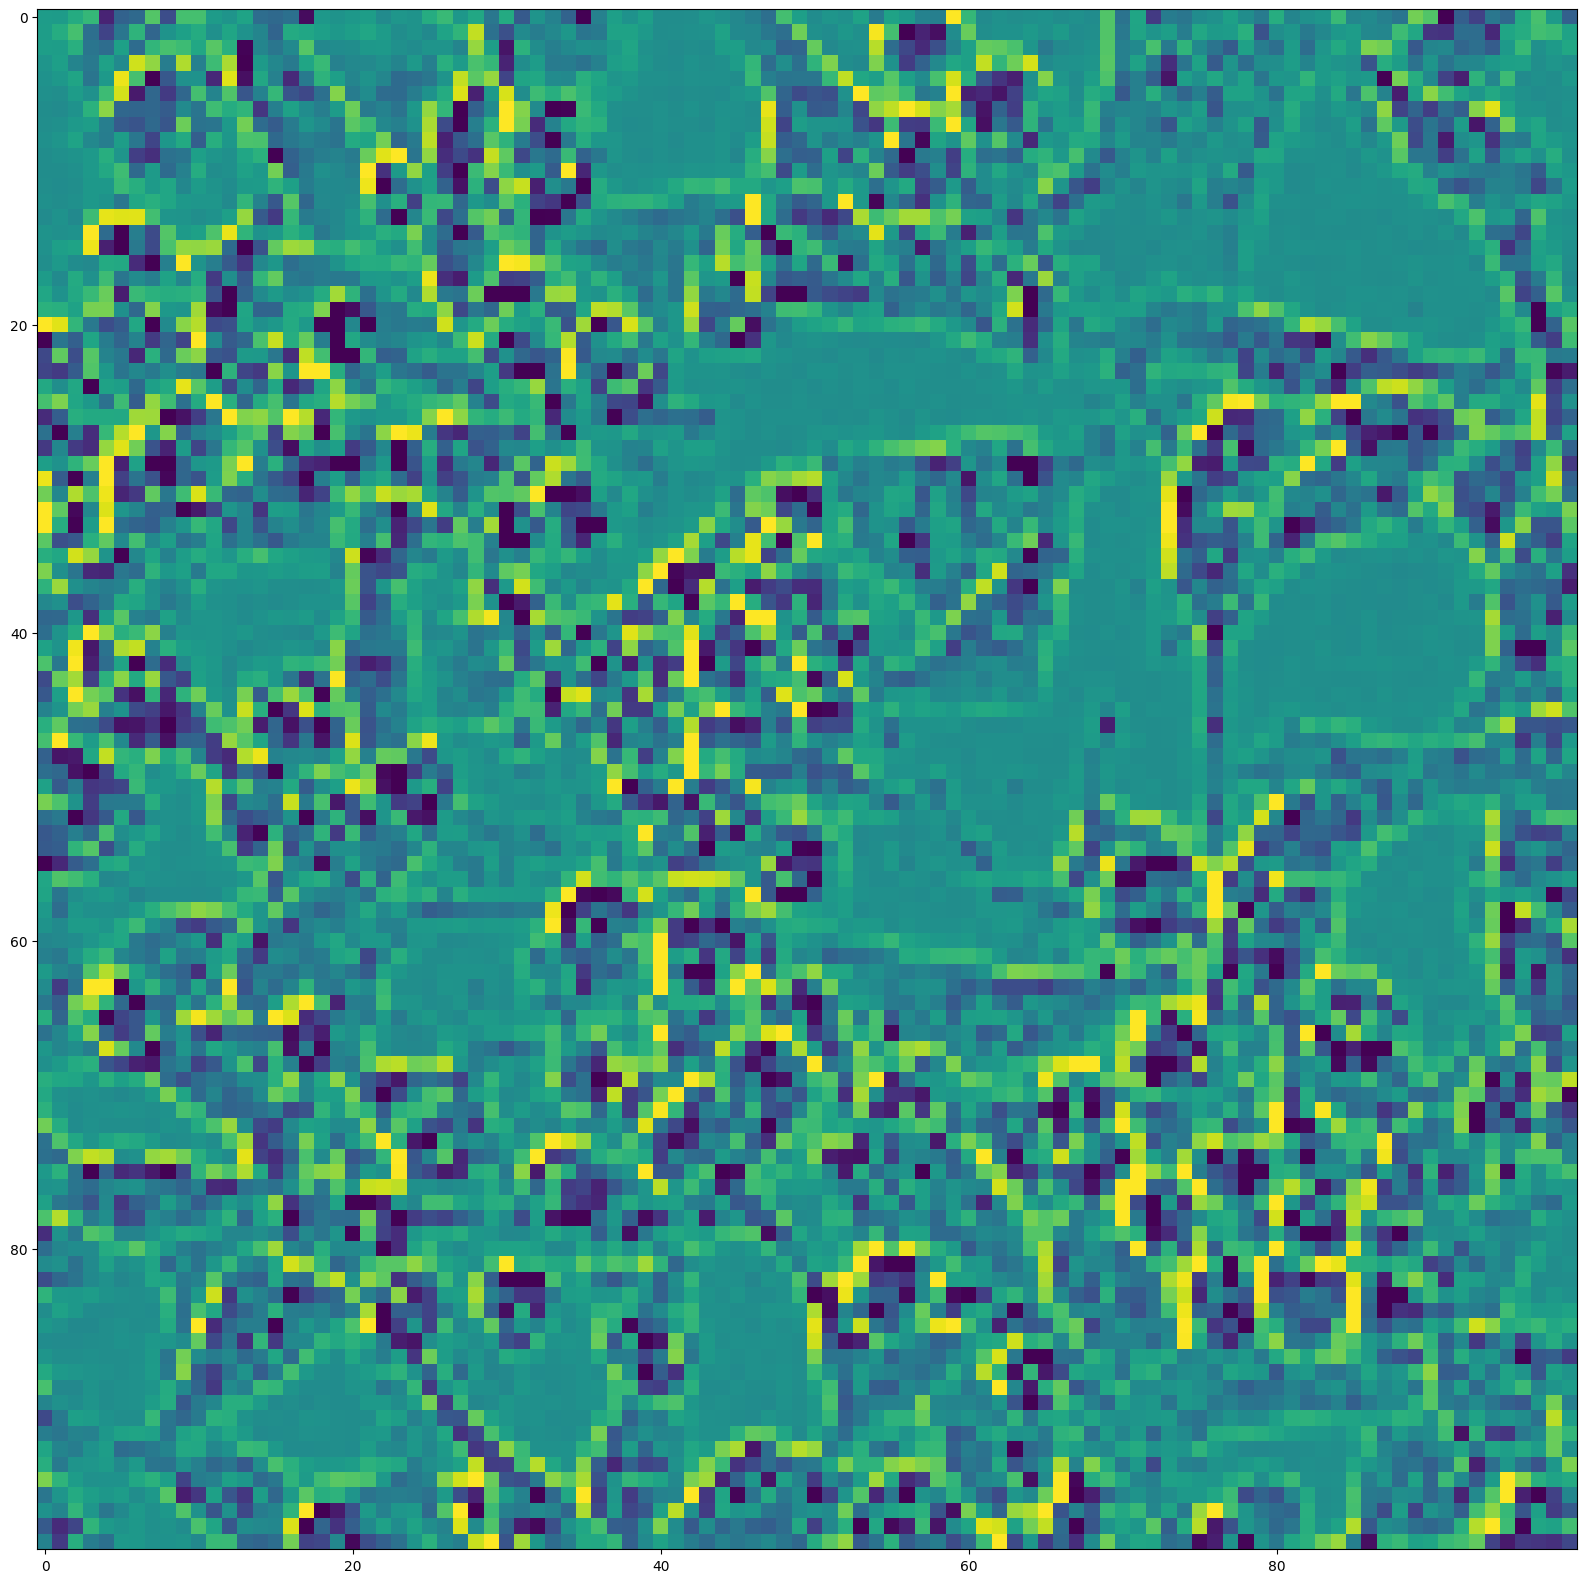

/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_05d14h00m.tif


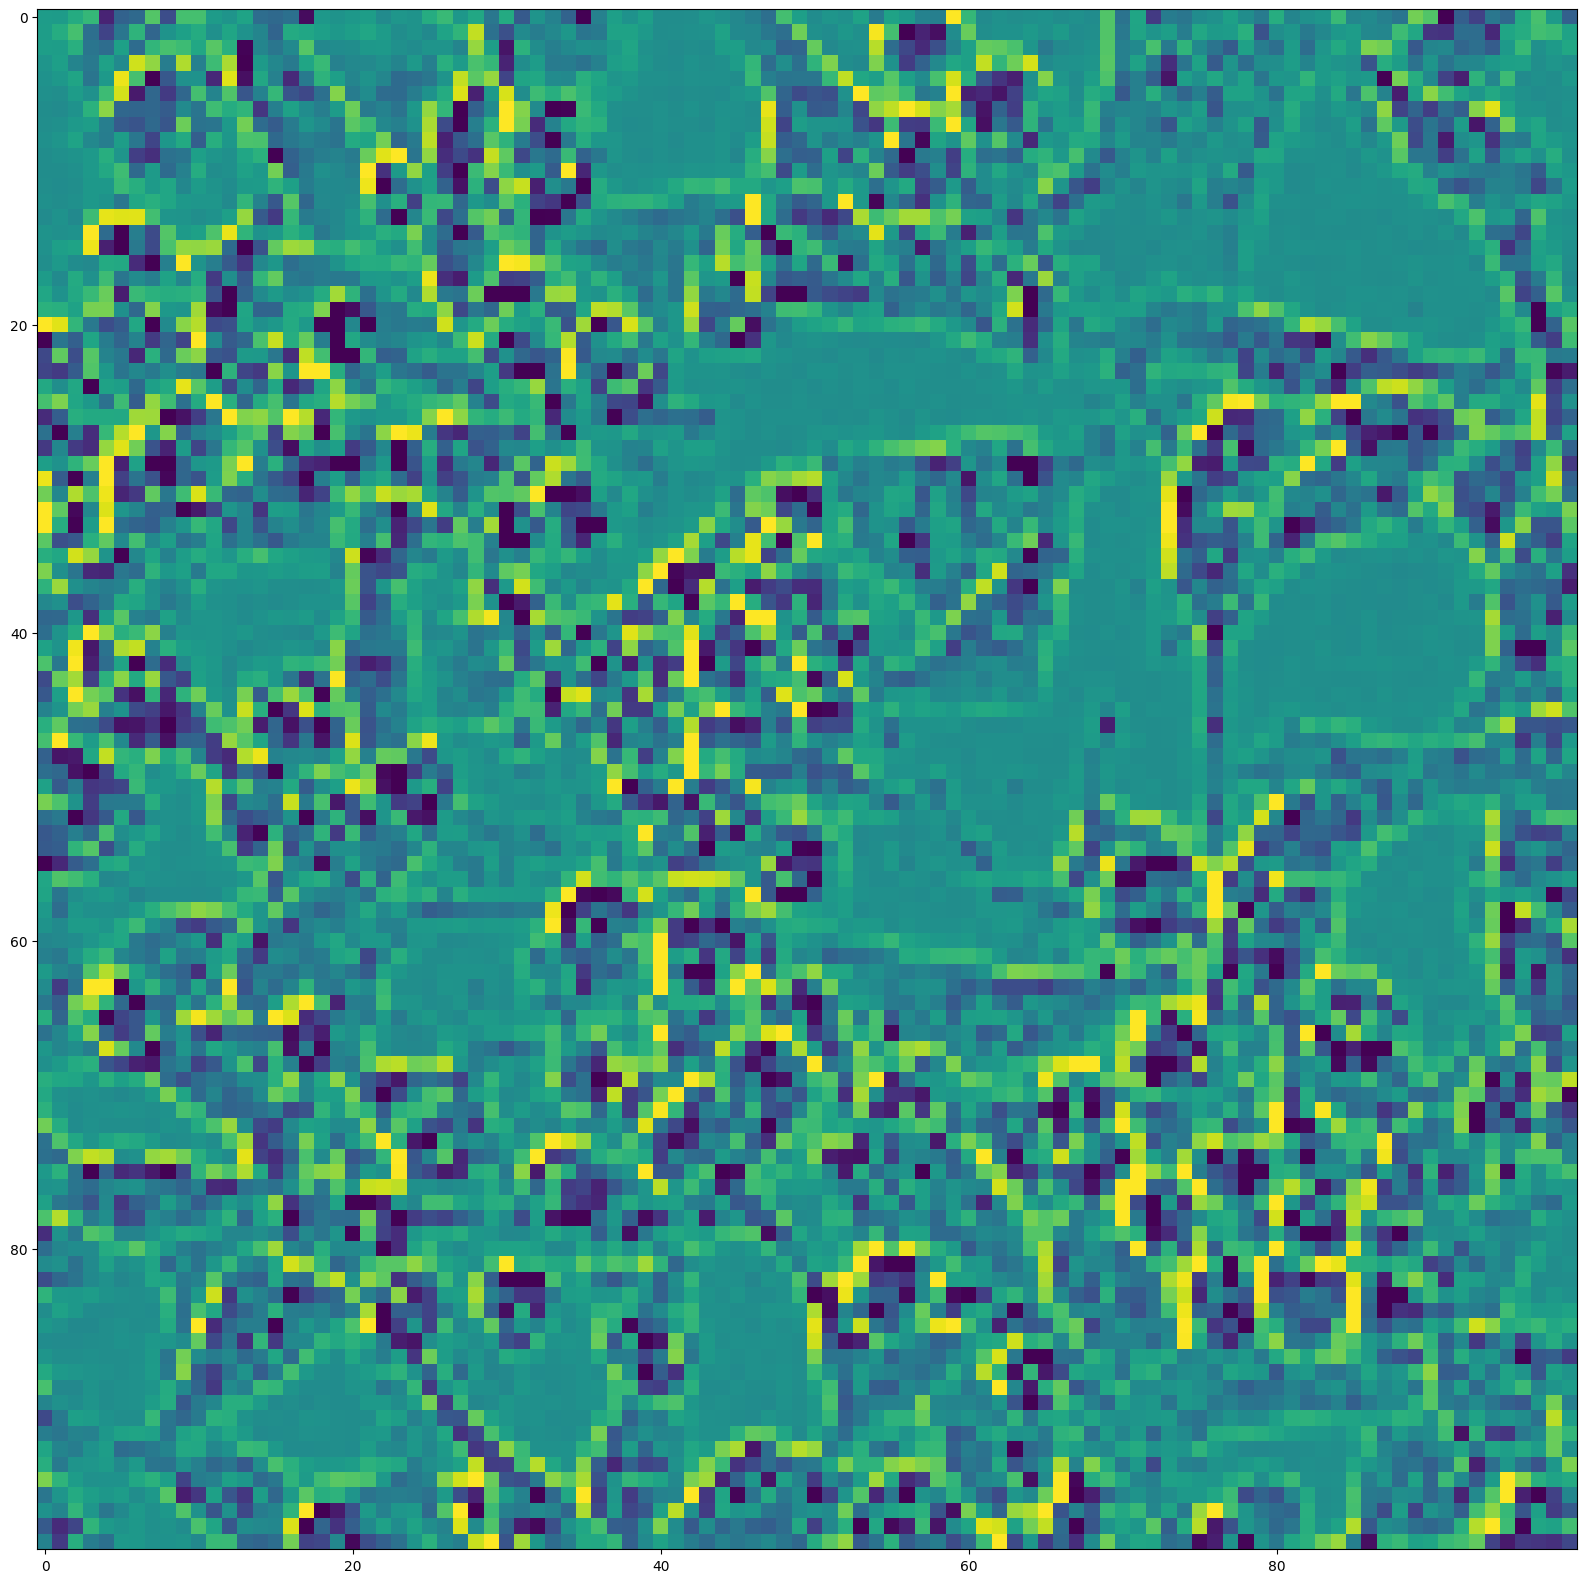

['/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d00h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d02h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d04h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d06h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d08h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d10h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d12h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_O3_1_00d14h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncuc

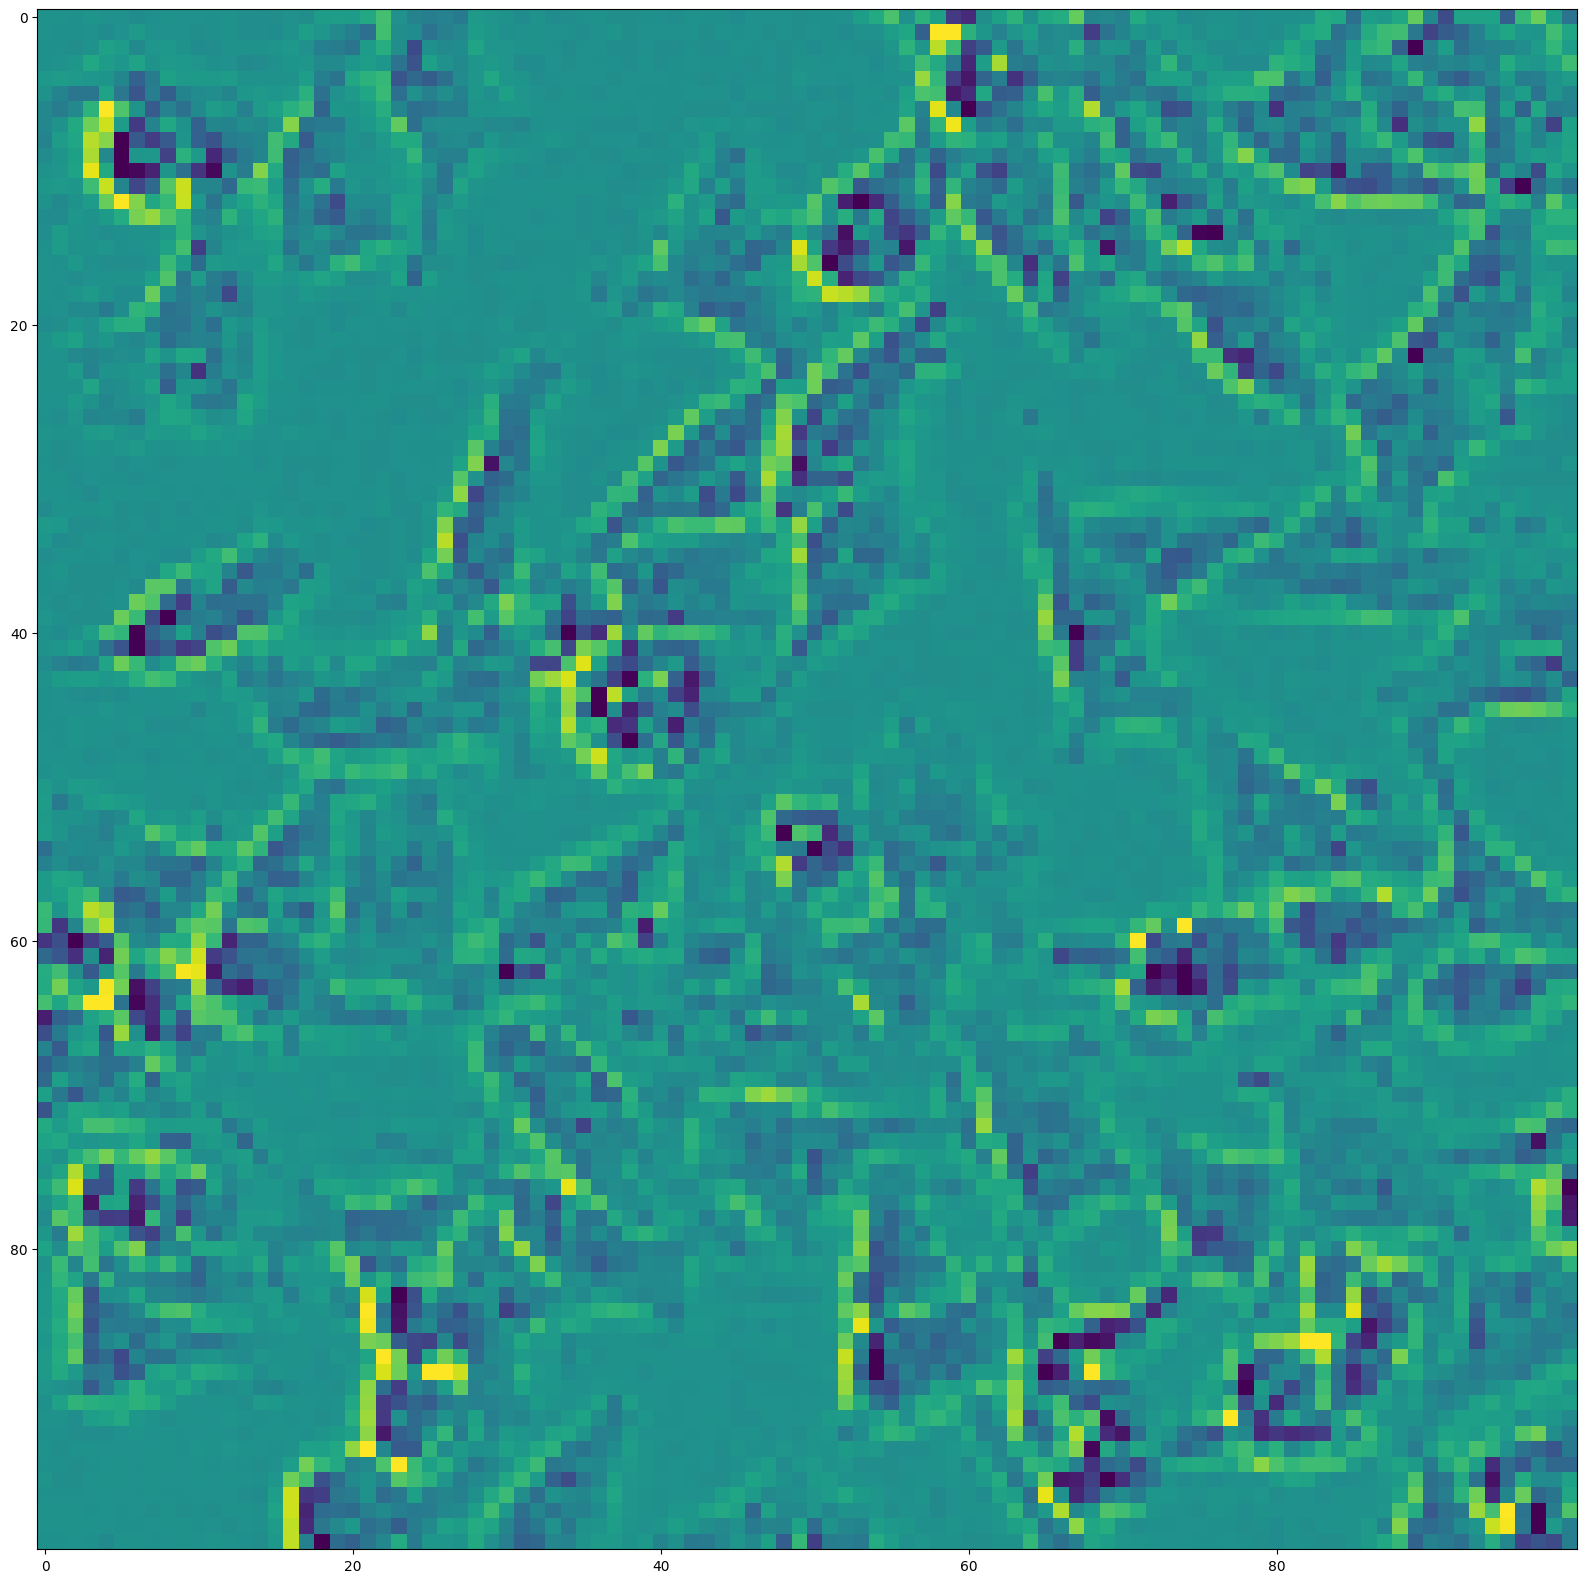

['/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d00h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d02h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d04h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d06h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d08h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d10h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d12h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_F3_1_00d14h00m.tif', '/Volumes/Engelhardt-Lab/MarsonLabIncuc

/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_M4_1_05d14h00m.tif
/Volumes/Engelhardt-Lab/MarsonLabIncucyteData/4DonorAssay/images/Donor4/phase/211107_Donor4_phase_B2_1_05d14h00m.tif


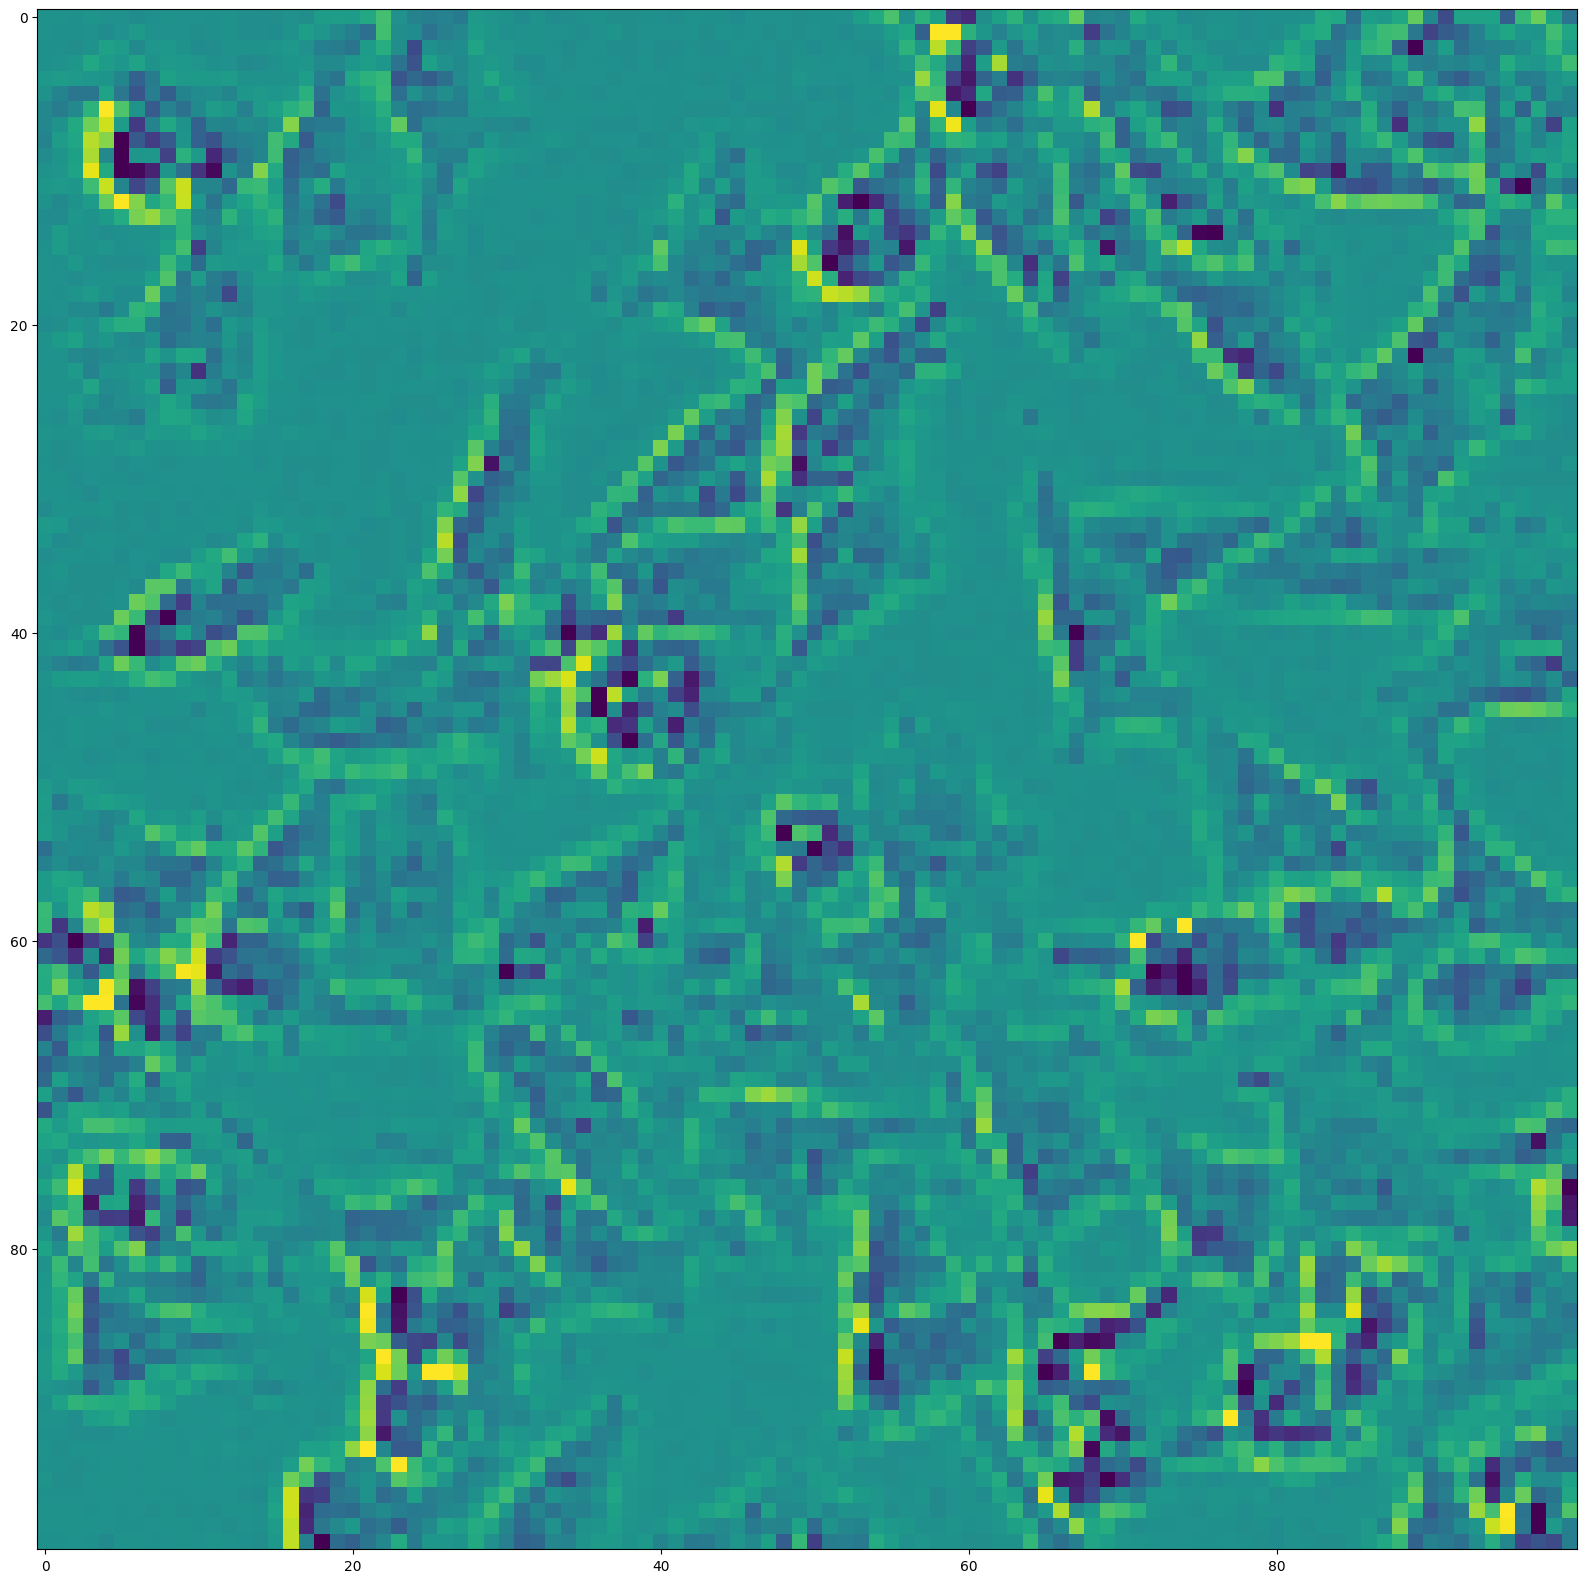

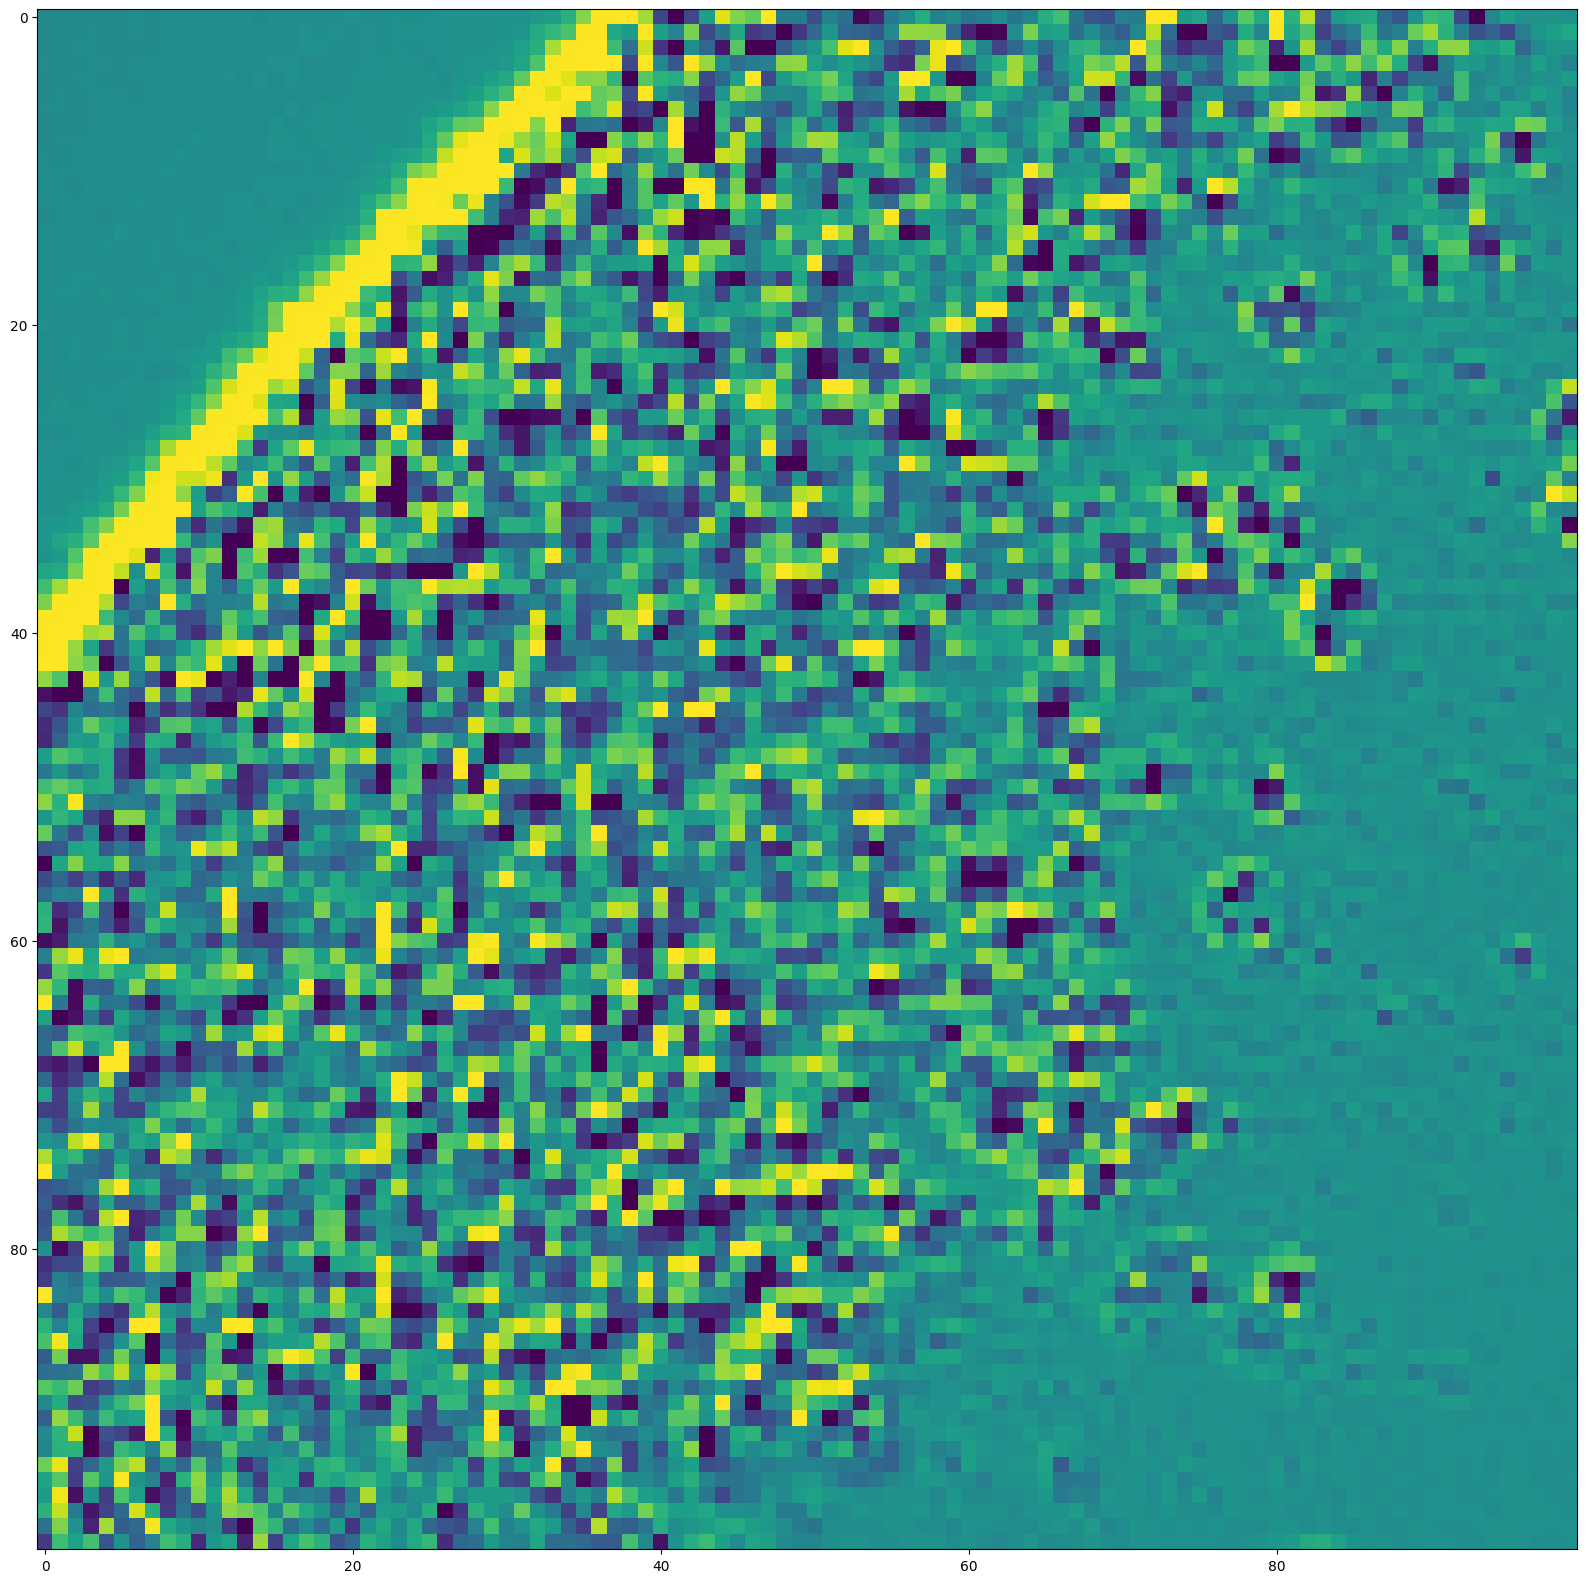

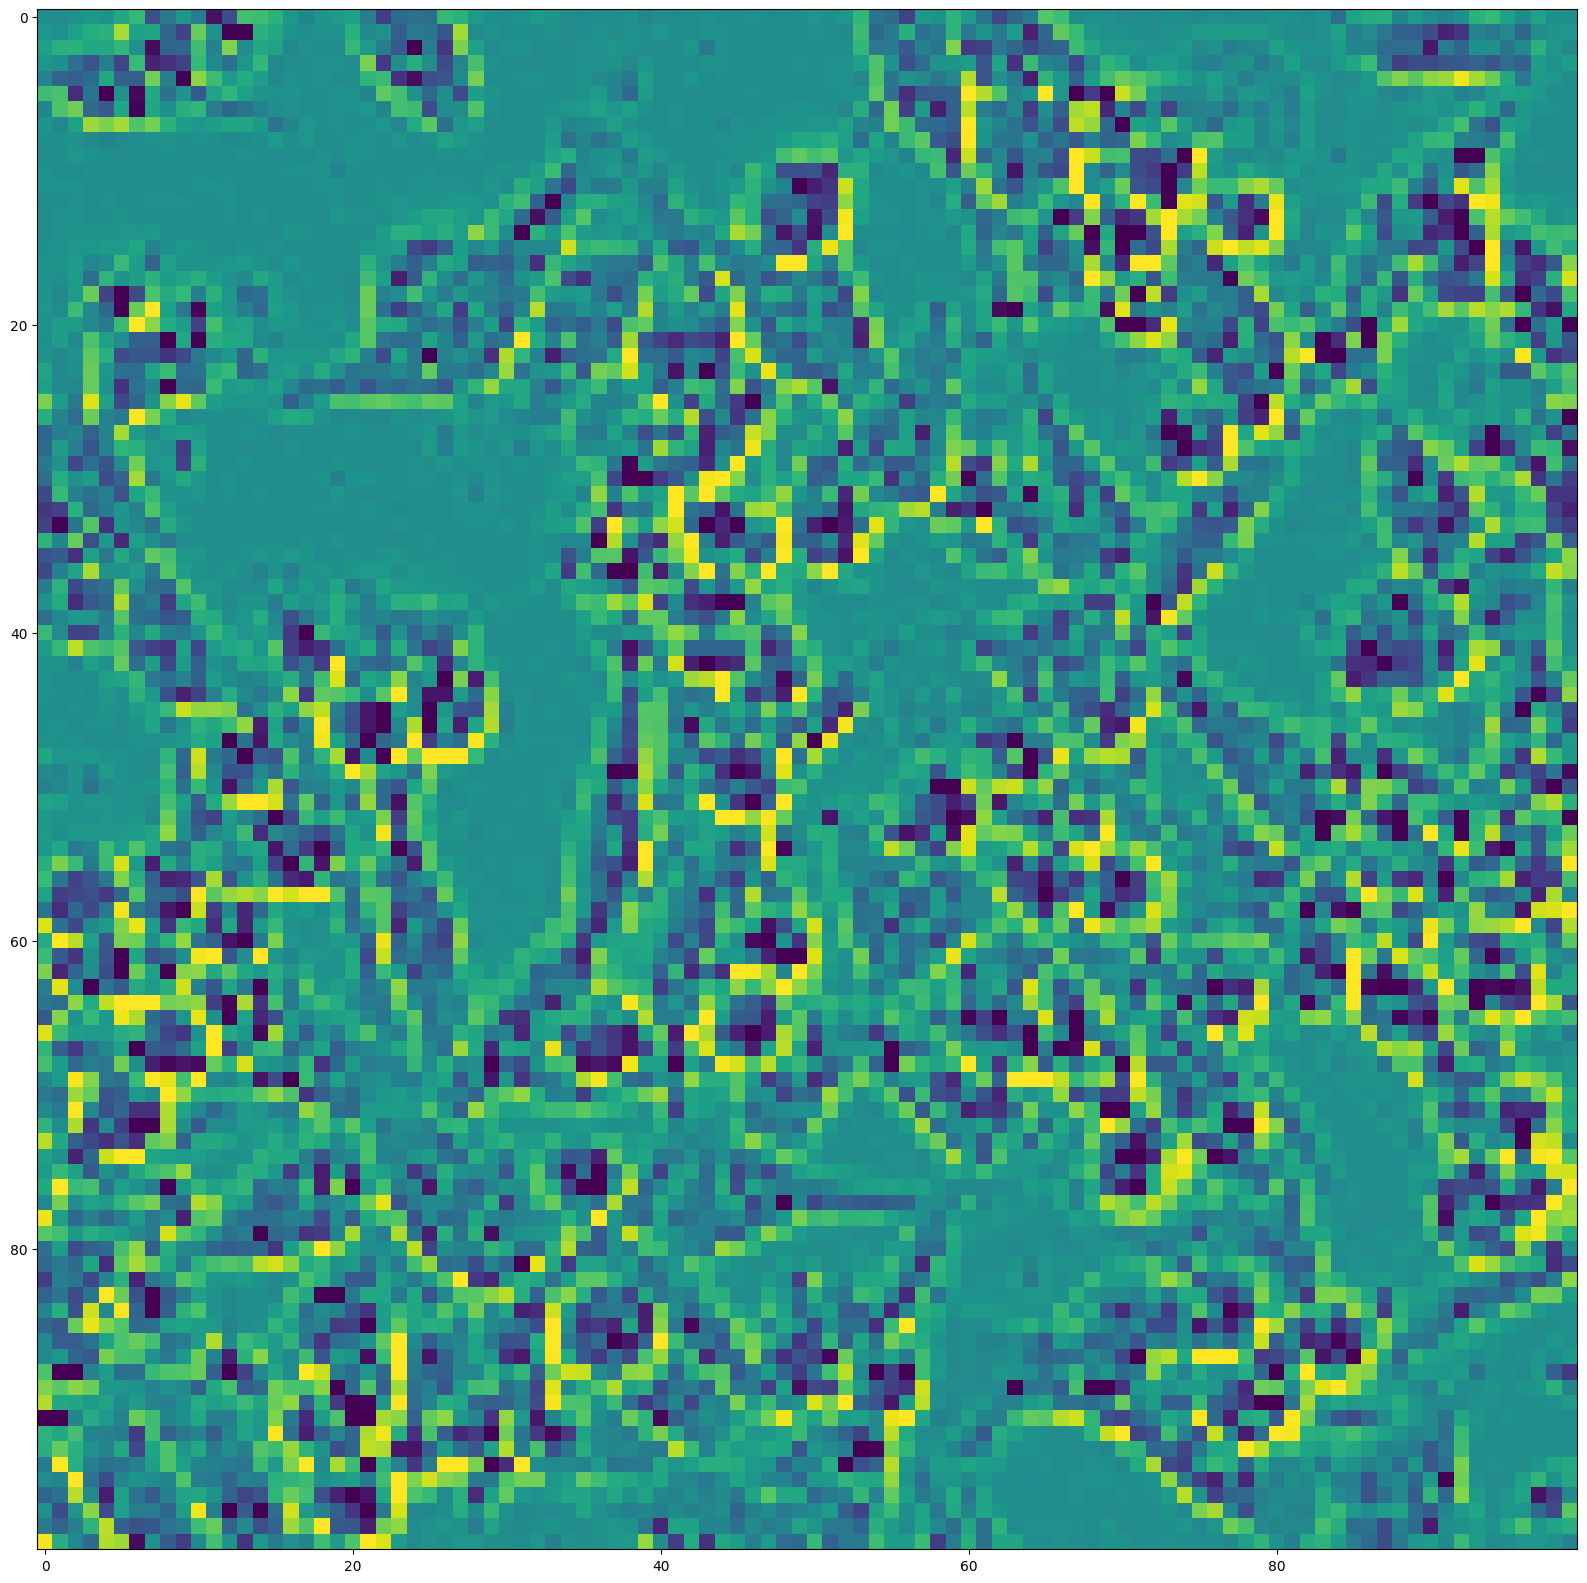

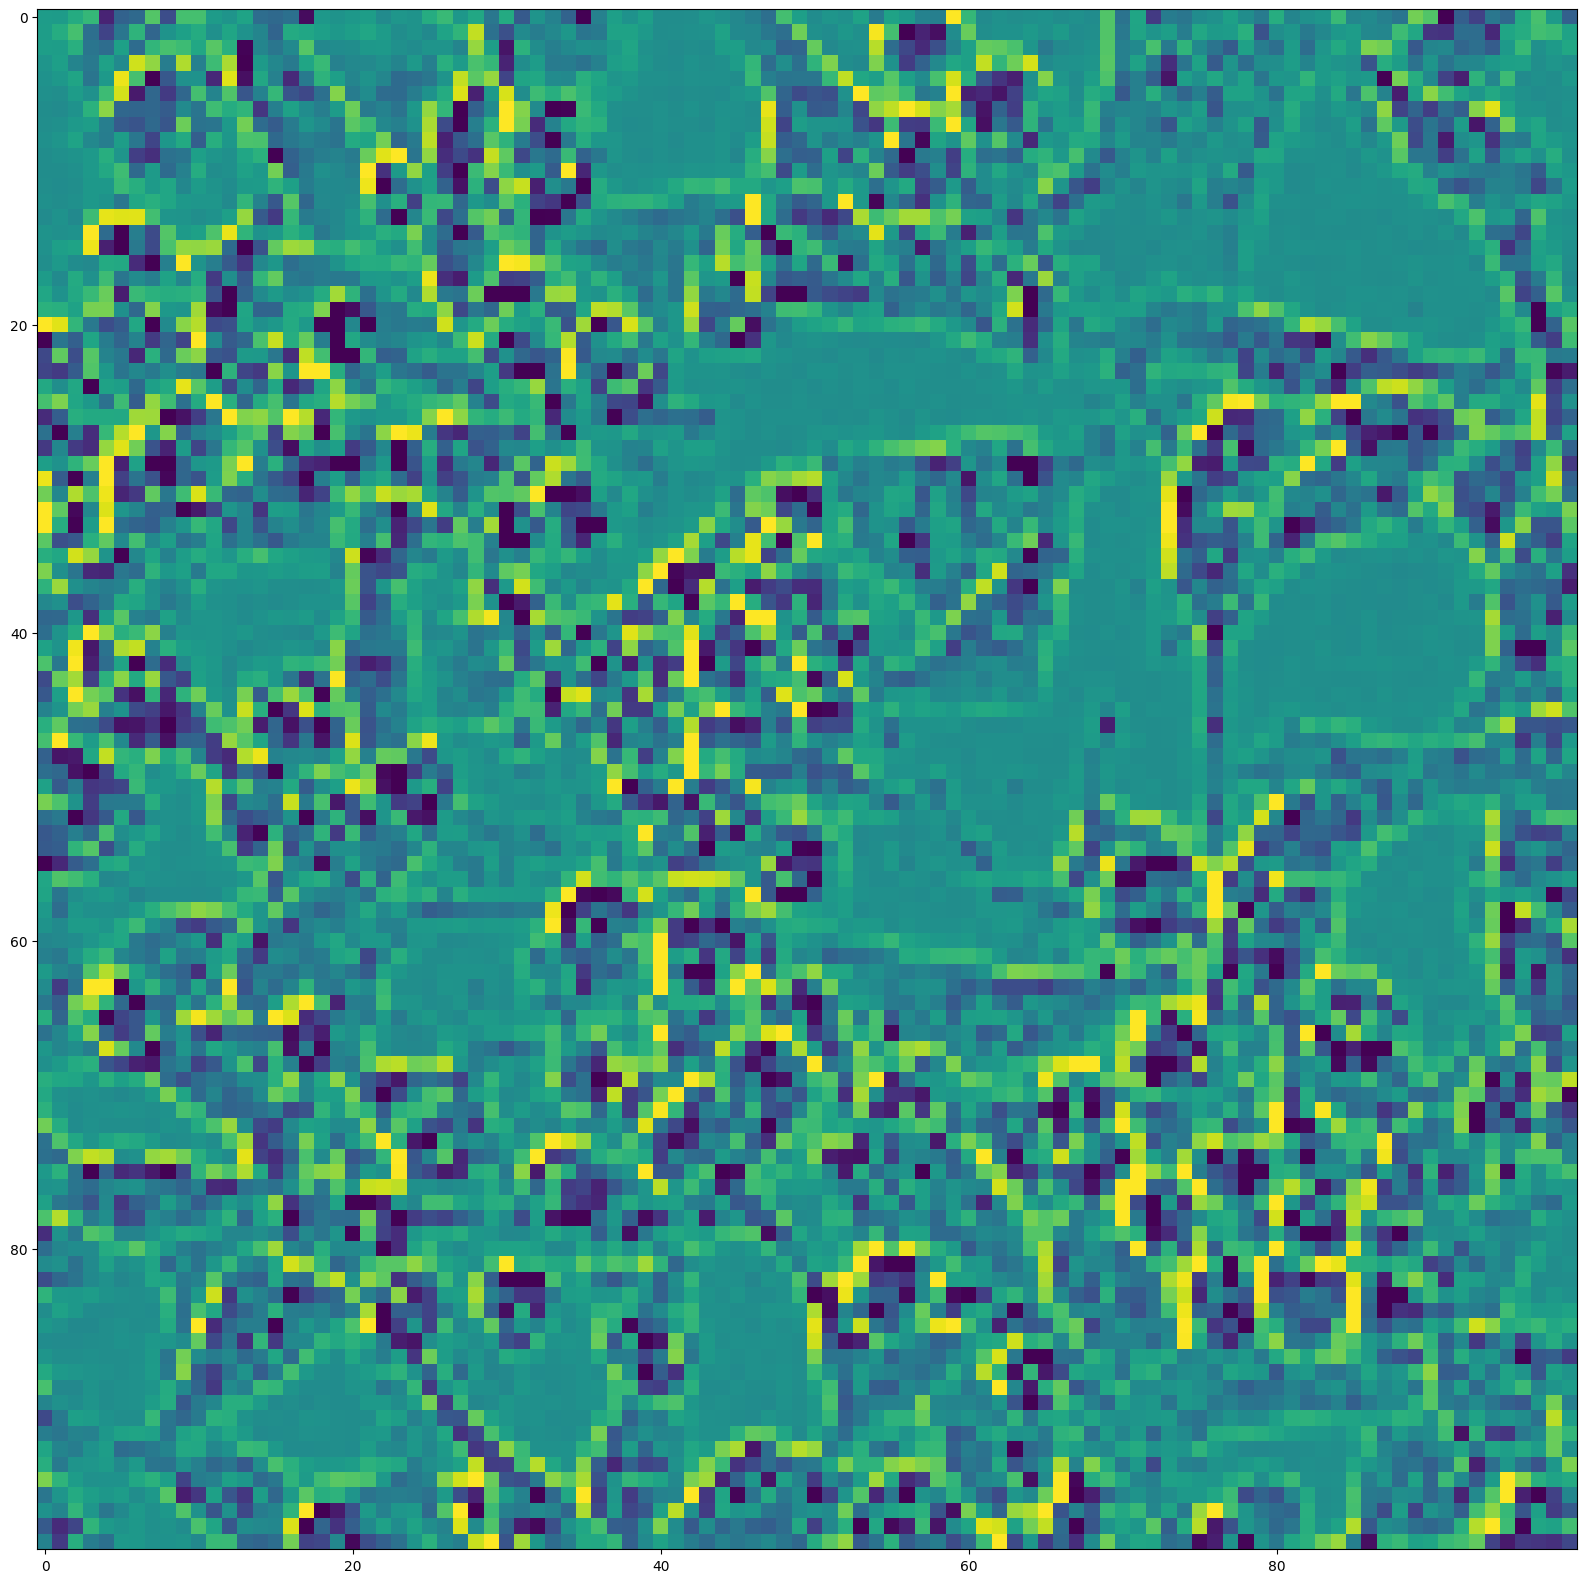

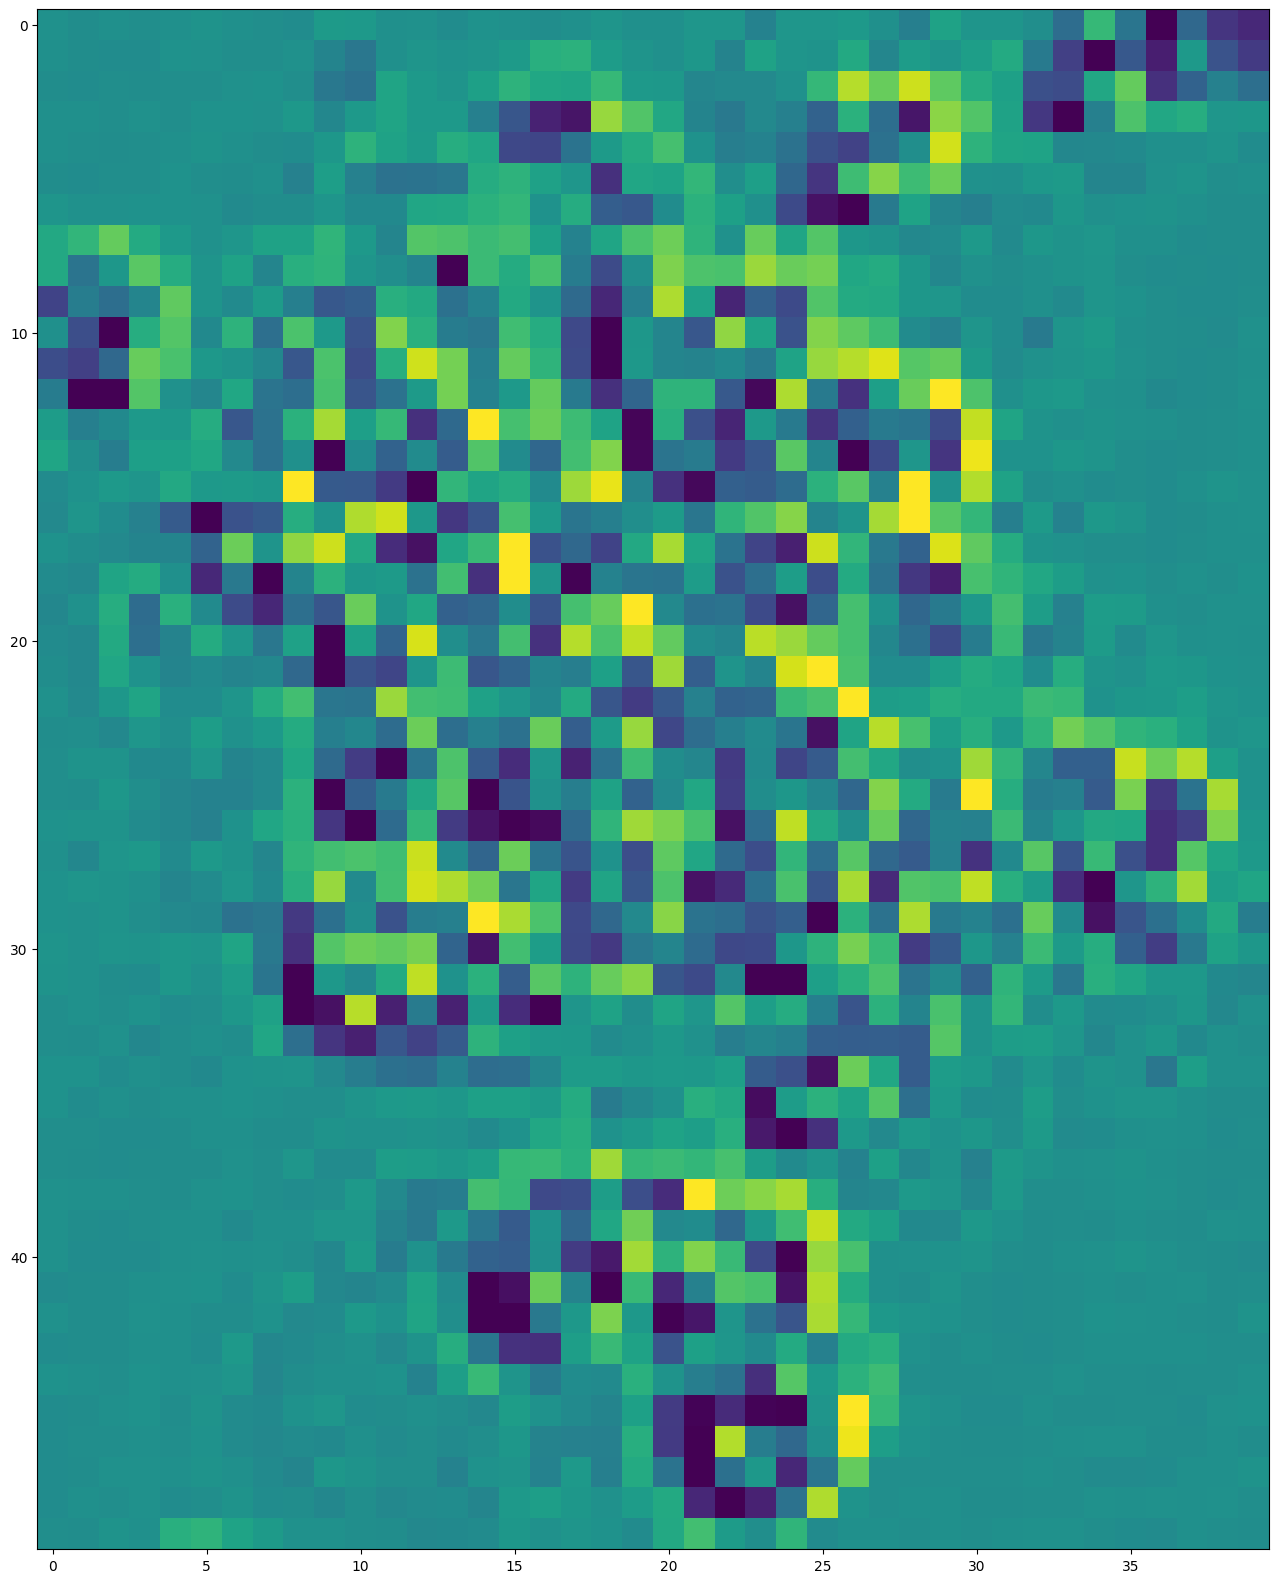

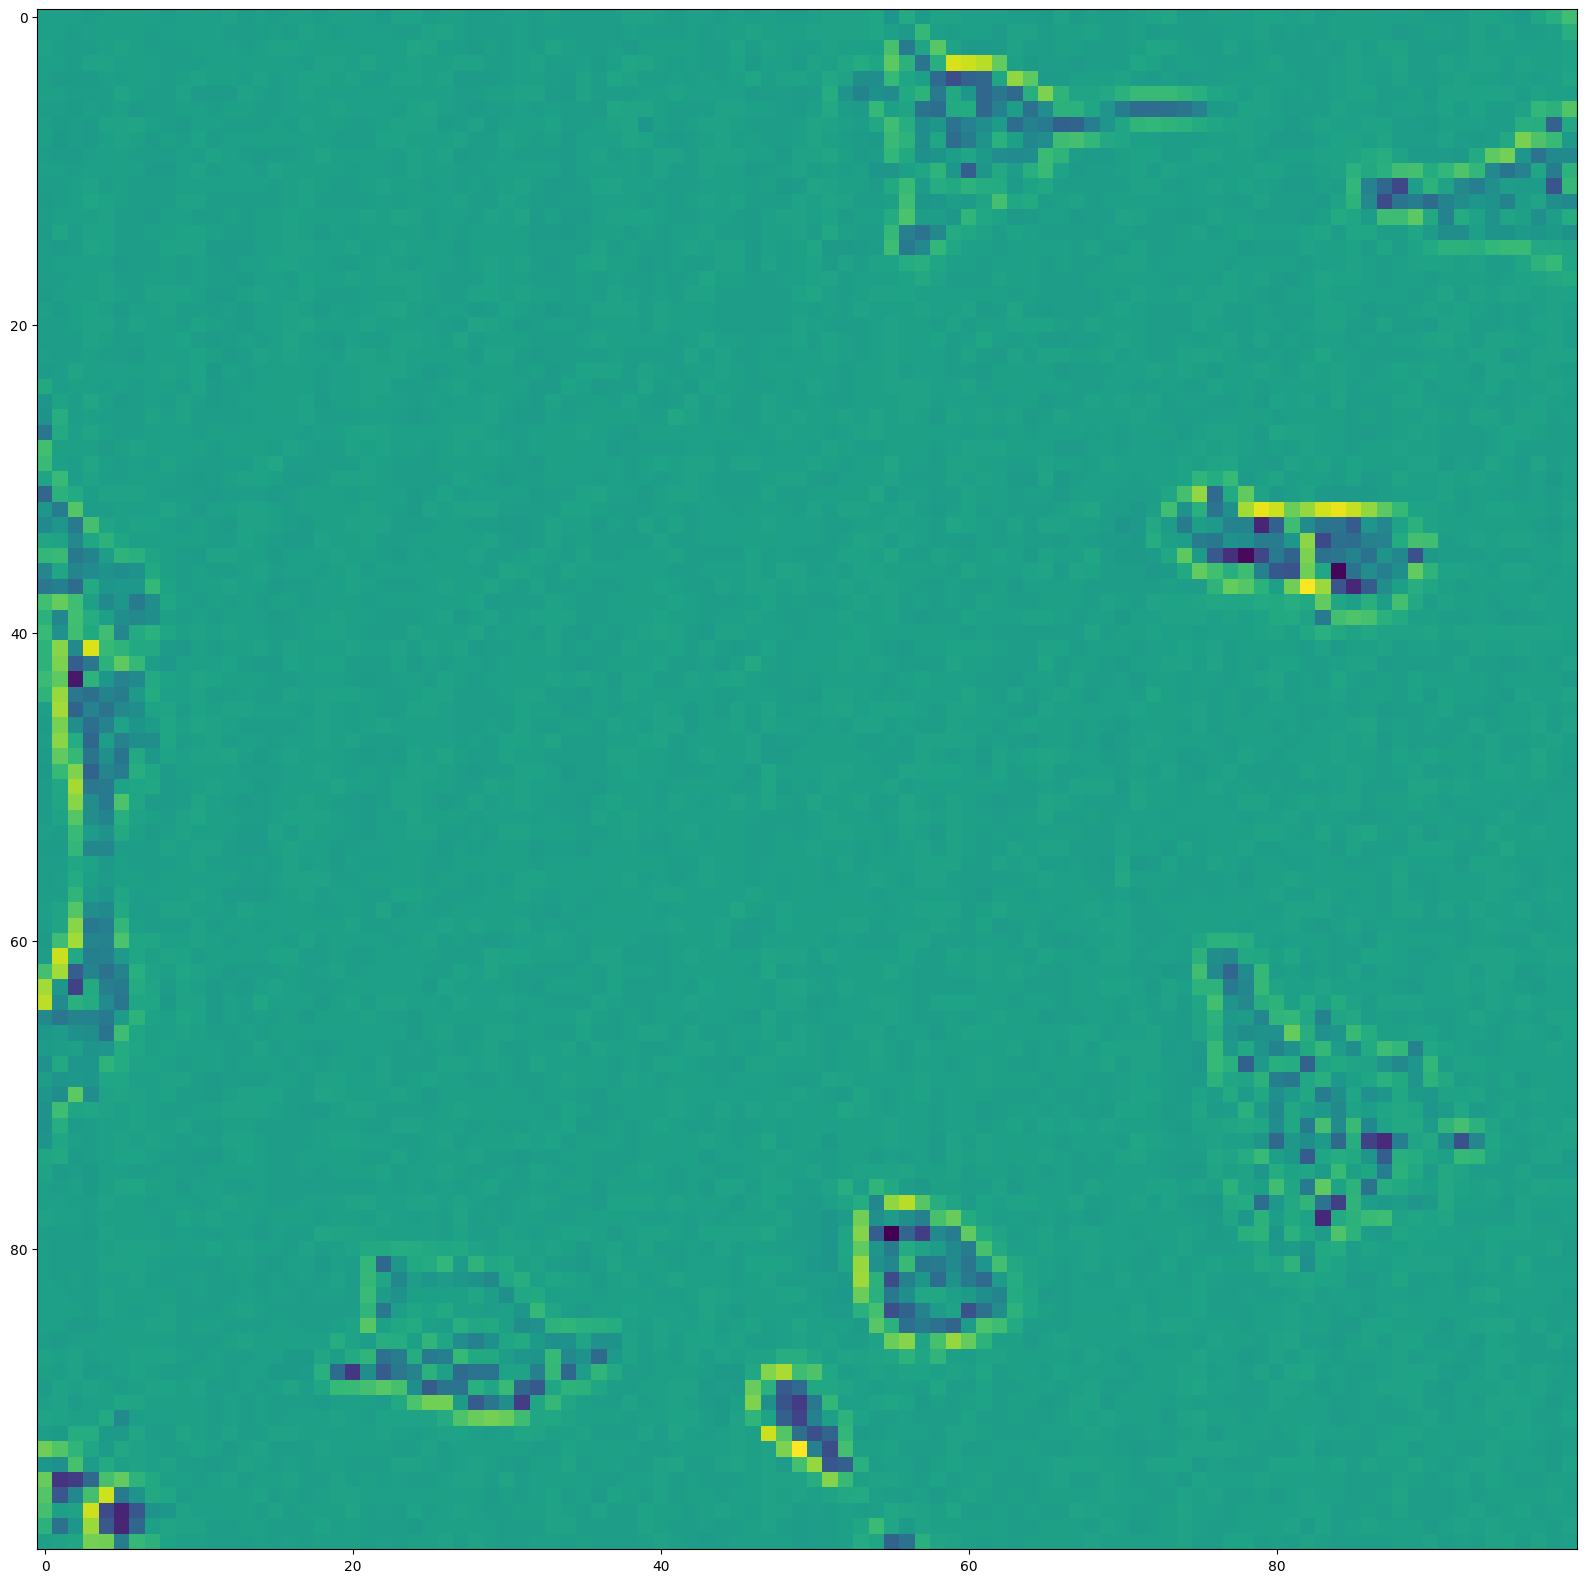

In [166]:
element = "O3"
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)
time = 15
plt.figure(figsize = (20,20))
plt.imshow(ayo[time,770:870,170:270])
###
element = "F3"
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)

plt.figure(figsize = (20,20))
time = 45
plt.imshow(ayo[time,200:300,200:300])
plt.figure(figsize = (20,20))
time = 45
plt.imshow(ayo[time,600:700,600:700])
####
element = diag_sort[-8]
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)

print(sorted_file_list[-1])
plt.figure(figsize = (20,20))
time = 34
plt.imshow(ayo[time,400:500,400:500])
###
element = diag_sort[0]
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)

print(sorted_file_list[-1])
plt.figure(figsize = (20,20))
time = 65
plt.imshow(ayo[time,425:475,790:830])

plt.figure(figsize = (20,20))
time = 0
plt.imshow(ayo[time,640:740,230:330])

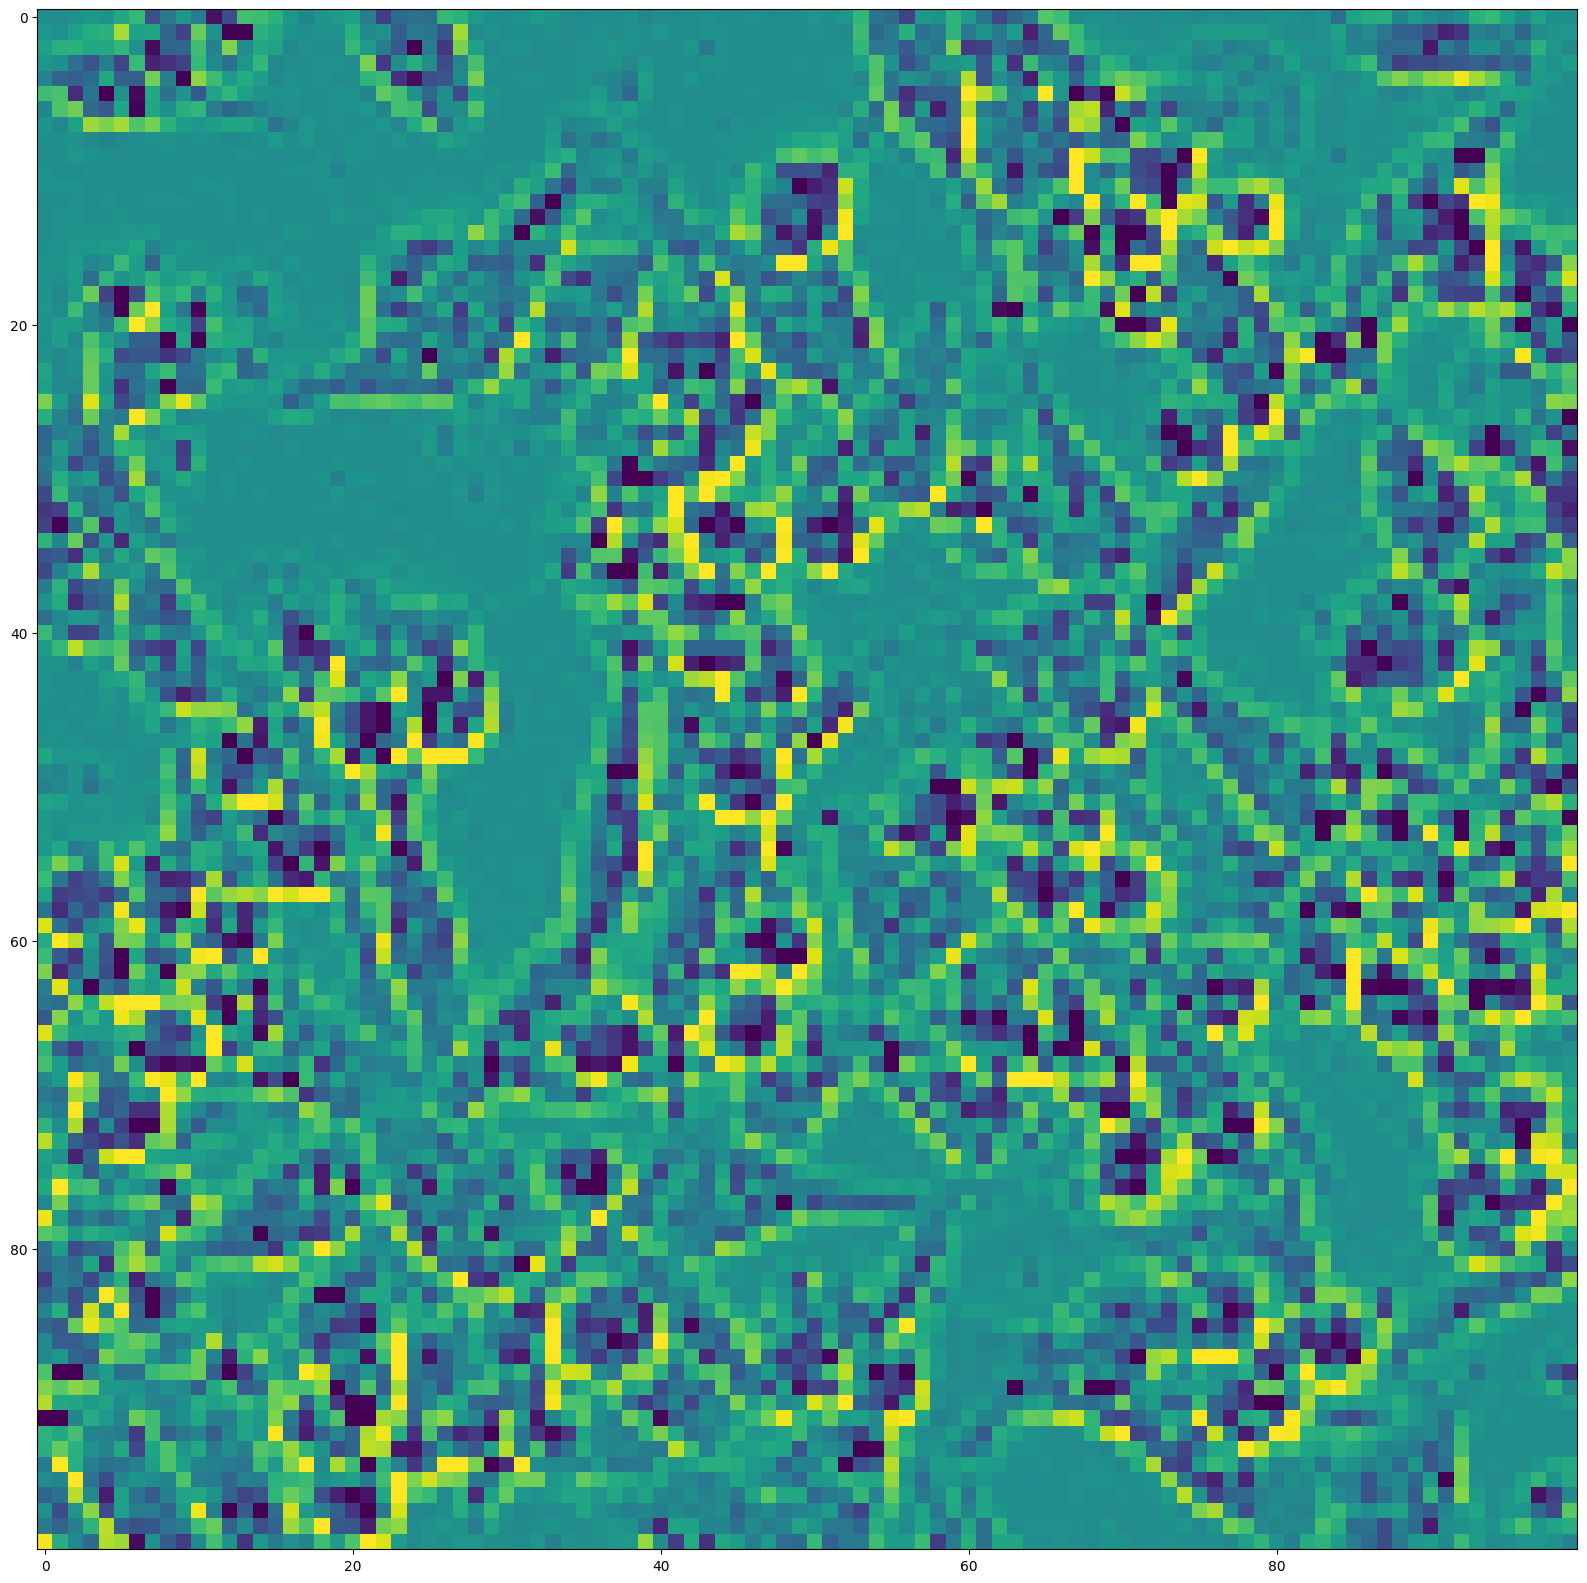

In [167]:
diag_sort

['B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6',
 'G7',
 'G8',
 'G9',
 'G10',
 'G11',
 'H2',
 'H3',
 'H4',
 'H5',
 'H6',
 'H7',
 'H8',
 'H9',
 'H10',
 'H11',
 'I2',
 'I3',
 'I4',
 'I5',
 'I6',
 'I7',
 'I8',
 'I9',
 'I10',
 'I11',
 'J2',
 'J3',
 'J4',
 'J5',
 'J6',
 'J7',
 'J8',
 'J9',
 'J10',
 'J11',
 'K2',
 'K3',
 'K4',
 'K5',
 'K6',
 'K7',
 'K8',
 'K9',
 'K10',
 'K11',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'L10',
 'L11',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'M10',
 'M11']

In [169]:
print(diag_sort[-1],diag_sort[-8],diag_sort[0])

M11 M4 B2
